# 0.0 IMPORTS

In [1]:
import sqlalchemy as db
import psycopg2   as pg
import pandas     as pd
import numpy      as np

import seaborn    as sns
import xgboost    as xgb
import random
import scikitplot as skplt
import os
import joblib
import pickle
import dotenv

from scipy      import stats  as ss
from matplotlib import gridspec
from sklearn    import preprocessing as pp
from sklearn    import model_selection as ms
from sklearn    import ensemble as en
from sklearn    import linear_model as lm
from lightgbm   import LGBMClassifier
from sklearn    import neighbors
from verstack   import LGBMTuner
from sklearn    import tree

from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

from matplotlib            import pyplot as plt
from IPython.core.display  import HTML
from IPython.display       import Image

## 0.1. Helper functions

In [2]:
def jupyter_settings():
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 10]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None

    sns.set()

def show_percentage(ax, df):
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2., height + 0.05, '{:.2f}%'.format(height*100/len(df)), ha="center")    
    
    
def cramer_v( x, y):
    #confusion matrix
    cm = pd.crosstab(x, y).values
    
    #sum of observations
    n = cm.sum()
    
    #number of lines and columns
    r, k = cm.shape
    
    #chi²
    chi2 = ss.chi2_contingency( cm )[0]
    
    #bias correction
    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))
    kcorr = k - (k-1)**2 / (n - 1)
    rcorr = r - (r-1)**2 / (n - 1)
    
    return np.sqrt( (chi2corr / n) / (min(kcorr -1, rcorr - 1)))


def precision_at_k(data, k = 20000):
    data = data.reset_index(drop=True)

    data['ranking'] = data.index +1

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']


def recall_at_k(data, k = 20000):
    data = data.reset_index(drop=True)

    data['ranking'] = data.index +1

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']



def precision_recall_at_k(model_name, x_val, y_val, y_prob, top_k = 20000):
    df8 = x_val.copy()
    df8['response'] = y_val.copy()

    df8['score'] = y_prob[:,1].tolist()

    # Sort by propensity score
    df8 = df8.sort_values(by='score', ascending=False).reset_index(drop=True)

    # Precision at k
    precision_at_x = round(precision_at_k(data = df8, k = top_k),4)
    recall_at_x = round(recall_at_k(data = df8, k = top_k),4)

    return pd.DataFrame({'Model Name': model_name,
                         'Precision at k': precision_at_x,
                         'Recall at k': recall_at_x}, index=[0])



def cross_validation (model_name, model, x_train, x_val,y_train,y_val, n_splits, n_repeats, top_k = 20000, verbose=False):
    
    if verbose:
        # the lenght_msg is to print only once a specific message
        length_msg = True
        i = 1
    
    # the seed usage provides repeatability 
    np.random.seed(42)
    
    # it is necessary to join the train and validation datasets
    x = pd.concat([x_train,x_val])
    y = pd.concat([y_train,y_val])
    
    
    # definition of the cross-validation strategy
    cv = ms.RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = n_repeats )
    
    precision_at_x = []
    recall_at_x = []
    
    for train_index, val_index in cv.split(x, y):      
        x_train_n , x_val_n = x.iloc[train_index], x.iloc[val_index]
        y_train_n, y_val_n = y.iloc[train_index], y.iloc[val_index]
        
        if (verbose == True) and (length_msg == True):
            print(f'training_lenght:{x_train_n.shape[0]}\nvalidation_lenght:{x_val_n.shape[0]}\n\n')
            length_msg = False
        
        if verbose:
            print(f'Iteration number:{i}')
            i += 1

        # fit and predict_proba
        model.fit(x_train_n, y_train_n)
        yhat_proba = model.predict_proba(x_val_n)

        df_aux = x_val_n.copy()
        df_aux['response'] = y_val_n.values
        df_aux['score'] = yhat_proba[:,1].tolist()

        # Sort by propensity score
        df_aux = df_aux.sort_values(by='score', ascending=False).reset_index(drop=True)       
    

        # save the metrics value to the list
        precision_at_x.append(precision_at_k(data = df_aux, k = top_k))
        recall_at_x.append(recall_at_k(data = df_aux, k = top_k))
        

    return pd.DataFrame({ 'Model Name': model_name,
                          'Precision': round(np.mean(precision_at_x), 3).astype(str) + '+/-' + round(np.std(precision_at_x),2).astype(str),
                          'Recall': round(np.mean(recall_at_x), 3).astype(str) + '+/-' + round(np.std(recall_at_x),2).astype(str)}, 
                          index=[0])

def ranking_score(x_val, y_val, y_hat):
        df_aux = x_val.copy()
        df_aux['response'] = y_val.values
        df_aux['score'] = y_hat[:,1].tolist()

        # Sort by propensity score
        df_aux = df_aux.sort_values(by='score', ascending=False).reset_index(drop=True)       
    
        df_aux['ranking'] = df_aux.index +1
        df_aux['recall_at_k'] = df_aux['response'].cumsum() / df_aux['response'].sum()
        df_aux['precision_at_k'] = df_aux['response'].cumsum() / df_aux['ranking']
    
        percents = np.arange(0.05, 1.05, 0.05)
        k_list = []

        for i in percents:
            k = int(len(df_aux)*i) - 1
            k_list.append( k )

        df_aux = df_aux.loc[k_list, ['score', 'precision_at_k', 'recall_at_k']]
        df_aux['k'] = percents
        df_aux = df_aux[['k', 'precision_at_k', 'recall_at_k', 'score']]
        df_aux = df_aux.reset_index(drop=True)

        return df_aux

In [3]:
jupyter_settings()

##  0.2. Collect data using Sqlalchemy

In [4]:
dotenv.load_dotenv(dotenv.find_dotenv()) # Credentials

True

In [5]:
# Credentials
HOST     = os.getenv('HOST')
PORT     = os.getenv('PORT')
DATABASE = os.getenv('DATABASE')
USERNAME = os.getenv('USERS')
PWD      = os.getenv('PWD')

In [ ]:
string_connect = 'postgresql://' + USERNAME + ':' + PWD + '@' + HOST + ':' + str(PORT) + '/' + DATABASE

engine = db.create_engine(string_connect)
conn1  = engine.connect()

In [7]:
query_schema = """
    SELECT u.*, v.driving_license, v.vehicle_age, v.vehicle_damage, i.previously_insured, i.annual_premium, i.vintage, i.response
    FROM pa004.users u
    JOIN pa004.vehicle v on u.id = v.id
    JOIN pa004.insurance i on u.id = i.id
"""

In [ ]:
df = pd.read_sql(query_schema, conn1)

In [129]:
data = df.drop('response', axis =1)
y = df.loc[:, 'response']

In [130]:
x_train, x_validation, y_train, y_validation = ms.train_test_split(data, y, test_size=0.2, random_state = 42)
x_train, x_test, y_train, y_test = ms.train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)

# 1.0. DATA DESCRIPTION

In [131]:
# Save data
df1 = pd.concat([x_train, y_train], axis = 1)
df1.head()

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,driving_license,vehicle_age,vehicle_damage,response
217927,216248,Female,26,27.0,26.0,0,26414.0,54,1,< 1 Year,Yes,0
54207,51476,Male,25,46.0,160.0,1,40329.0,63,1,< 1 Year,No,0
18364,146718,Female,81,8.0,124.0,1,47136.0,207,1,1-2 Year,No,0
195540,37496,Male,69,28.0,59.0,0,66837.0,39,1,1-2 Year,Yes,0
30463,243026,Male,37,3.0,124.0,0,89605.0,254,1,1-2 Year,Yes,0


## 1.1. Rename Columns

There's no need to change anything about the columns, they are all correct.

In [132]:
df1.columns.tolist()

['id',
 'gender',
 'age',
 'region_code',
 'policy_sales_channel',
 'previously_insured',
 'annual_premium',
 'vintage',
 'driving_license',
 'vehicle_age',
 'vehicle_damage',
 'response']

## 1.2. Data Dimensions

In [133]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of cols: {df1.shape[1]}')

Number of rows: 243909
Number of cols: 12


## 1.3. Data Types

In [134]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
previously_insured        int64
annual_premium          float64
vintage                   int64
driving_license           int64
vehicle_age              object
vehicle_damage           object
response                  int64
dtype: object

## 1.4. Check NA

We have no empty data, no need to fill anything

In [135]:
df1.isnull().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
previously_insured      0
annual_premium          0
vintage                 0
driving_license         0
vehicle_age             0
vehicle_damage          0
response                0
dtype: int64

## 1.5. Change Types

In [136]:
# region code
df1['region_code'] = df1['region_code'].astype('int64')

# policy channel
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype('int64')

## 1.6. Columns Description

| **Feature**             | **Description**                                                                                                                   |
|-------------------------|-----------------------------------------------------------------------------------------------------------------------------------|
|**ID**                   | _Unique ID for the customer_                                                                                                      |
|**Gender**               | _Gender of the customer_                                                                                                          |
|**Age**                  | _Age of the customer_                                                                                                             |
|**Driving_License**      | _Customer does not have DL / Customer already has DL_                                                                             |
|**Region_Code**          | _Unique code for the region of the customer_                                                                                      |
|**Previously_Insured**   | _Customer already has Vehicle Insurance / Customer doesn't have Vehicle Insurance_                                                |
|**Vehicle_Age**          | _Age of the Vehicle_                                                                                                              |
|**Vehicle_Damage**       | _Customer got his vehicle damaged in the past. / Customer didn't get his/her vehicle damaged in the past._                        |
|**Annual_Premium**       | _The amount customer needs to pay as premium in the year_                                                                         |
|**Policy_Sales_Channel** | _Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc._     |
|**Vintage**              | _Number of Days, Customer has been associated with the company_                                                                   |
|**Response**             | _Customer is interested / Customer is not interested_                                                                             |

## 1.7. Data Statistical

In [137]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(include=['object'])

### 1.7.1. Numerical Attributes

In [138]:
min_       =  pd.DataFrame(num_attributes.apply(np.min)).T
max_       =  pd.DataFrame(num_attributes.apply(np.max)).T
mean_      =  pd.DataFrame(num_attributes.apply(np.mean)).T
median_    =  pd.DataFrame(num_attributes.apply(np.median)).T
std_       =  pd.DataFrame(num_attributes.apply(np.std)).T
range_     =  pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
skew_      =  pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
kurtosis_  =  pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

In [139]:
data_statistical = pd.concat([min_, max_, range_, mean_, median_, std_, skew_, kurtosis_]).T.reset_index()
data_statistical.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

data_statistical

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190629.391027,190463.0,110113.314639,0.000958,-1.202639
1,age,20.0,85.0,65.0,38.840338,36.0,15.504093,0.670266,-0.567091
2,region_code,0.0,52.0,52.0,26.395664,28.0,13.225380,-0.116015,-0.864970
3,policy_sales_channel,1.0,163.0,162.0,111.872969,125.0,54.265997,-0.893386,-0.983596
4,previously_insured,0.0,1.0,1.0,0.458667,0.0,0.498289,0.165901,-1.972493
5,annual_premium,2630.0,540165.0,537535.0,30608.226572,31699.0,17212.946509,1.719756,32.837156
6,vintage,10.0,299.0,289.0,154.297090,154.0,83.710513,0.002952,-1.201692
7,driving_license,0.0,1.0,1.0,0.997827,1.0,0.046564,-21.382550,455.217194
8,response,0.0,1.0,1.0,0.122697,0.0,0.328090,2.300012,3.290082


### 1.7.2. Categorical Attributes

In [140]:
# number of unique categories in each object columns
cat_attributes.apply(lambda x: x.unique().shape[0])

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

In [141]:
for i in cat_attributes.columns:
    print(f'{i}: {cat_attributes[i].unique()}')


gender: ['Female' 'Male']
vehicle_age: ['< 1 Year' '1-2 Year' '> 2 Years']
vehicle_damage: ['Yes' 'No']


* I have 8% more male customers in my database.    
* Vehicles aged between 1 to 2 years are the predominant class of vehicle_age 
* Vehicle damage is balanced


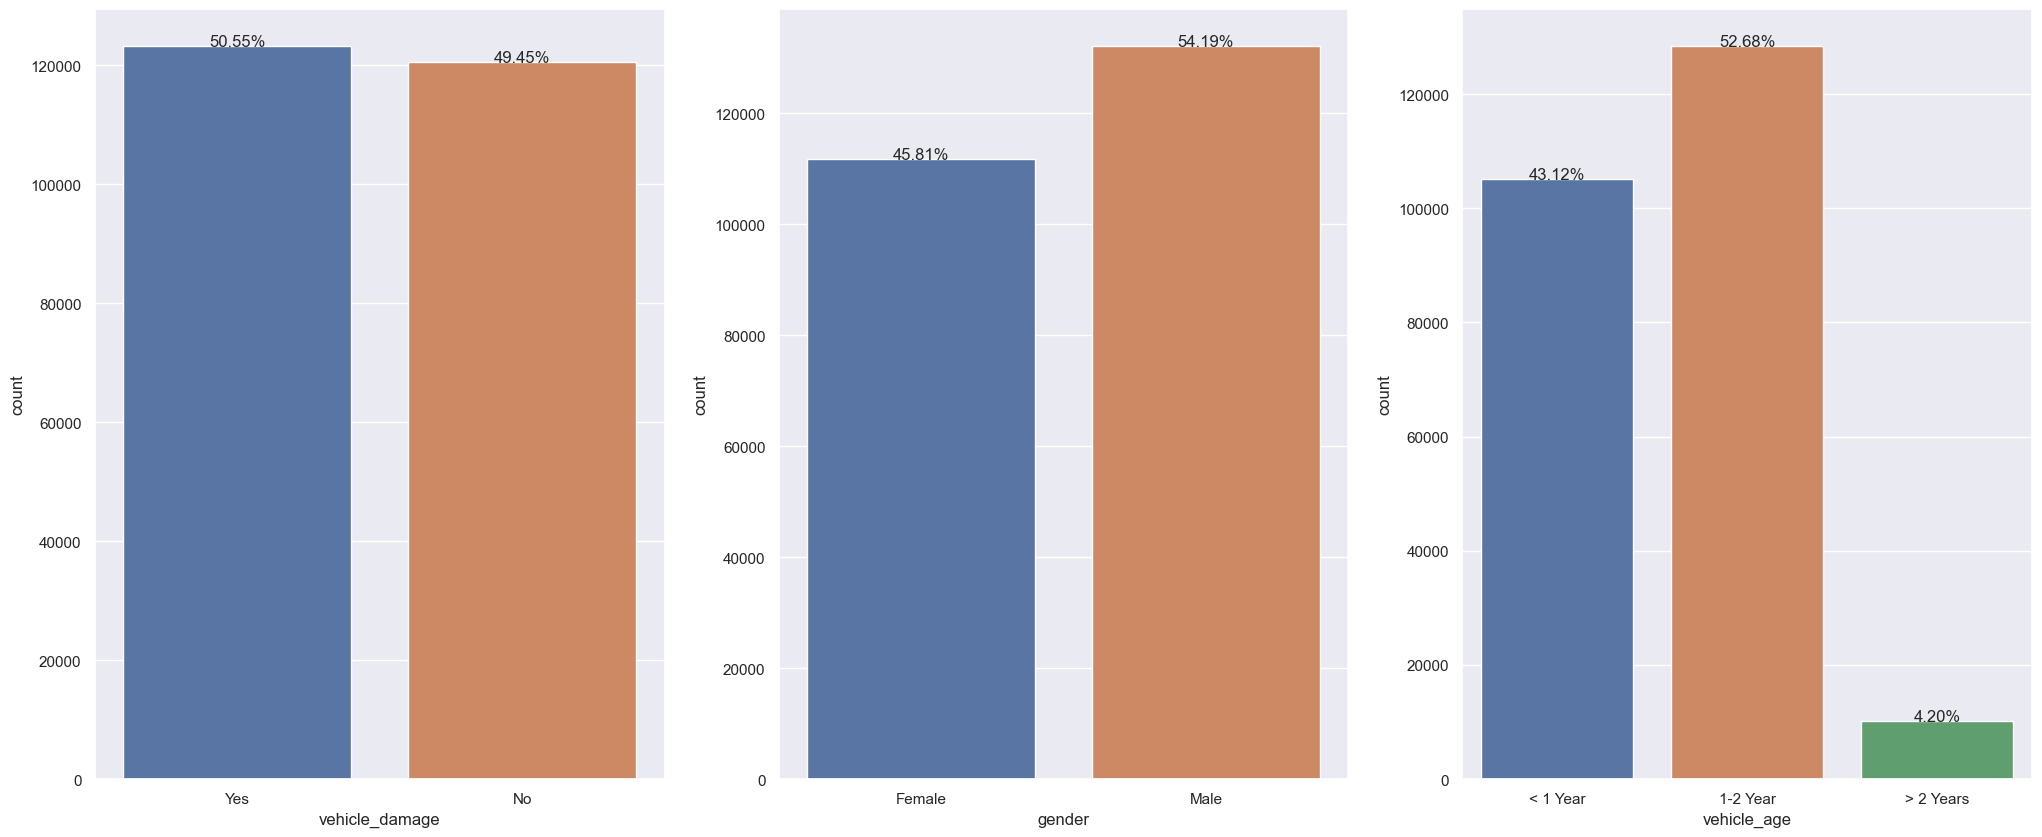

In [142]:
# Gender
plt.subplot(1, 3, 2)
ax1 = sns.countplot(x = 'gender',  data = df1)
show_percentage(ax1, df1)

# Vehicle age
plt.subplot(1, 3, 3)
ax2 = sns.countplot(x = 'vehicle_age',  data = df1)
show_percentage(ax2, df1)

# Vehicle Damage
plt.subplot(1, 3, 1)
ax = sns.countplot(x = 'vehicle_damage',  data = df1)
show_percentage(ax, df1);

# 2.0. FEATURE ENGINEERING

In [143]:
df2 = df1.copy()

## 2.1. Mindmap Of Hipotesys

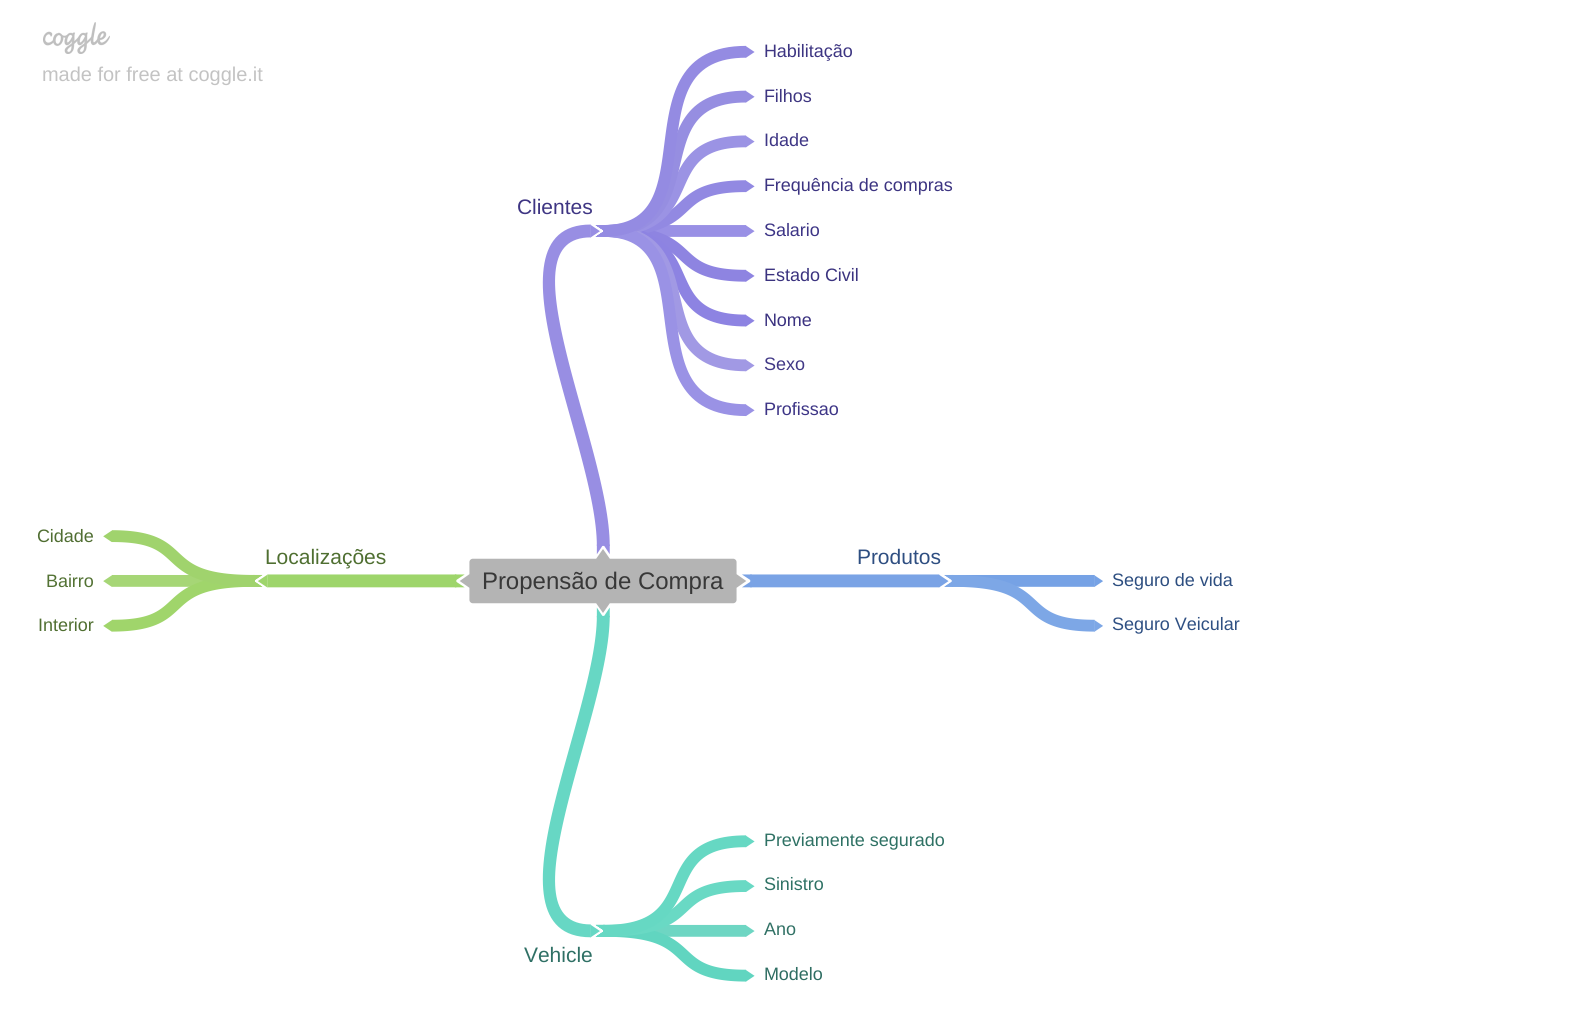

In [144]:
Image('img/Propensao_de_compra.png')

## 2.2. List of Hipotesys

#### Customers

1. Customers who have a driver's license are more likely to purchase a second insurance.
2. Customers over the age of 35 are more likely to purchase a second insurance.
3. Female customers are more likely to purchase a second insurance.
4. Customers who have been clients for a longer period of time are more likely to purchase a second insurance.

#### Products 

5. The propensity to purchase a second insurance is higher for customers who have already purchased another insurance previously.

#### Vehicle

6. Customers with a vehicle over two years old have a higher probability of acquiring a new insurance.
7. Customers with an annual premium above 10000 have a higher probability of acquiring a new insurance.
8. Customers who have already purchased an insurance and had their vehicle damaged are more likely to buy a new insurance.

## 2.3. Feature Engineering

### 2.3.1 Training Dataset

In [145]:
# Turn gender to numeric variable
df2['gender'] = df2['gender'].apply(lambda x: 1 if x == 'Male' else 0)

# Turn vehicle_damage to numeric variable
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# 
df2['vehicle_age']  = df2['vehicle_age'].apply(lambda x: 'over_2_year' if x == '> 2 Years' else 
                                                         'between_1_2_year' if x == '1-2 Year' else 
                                                         'below_1_year')

# annual premium per day
df2['ap_per_day'] = df2['annual_premium'] / df2['vintage']

# annual premium per age
df2['ap_per_age'] = df2['annual_premium'] / df2['age']


# previously insured per day
df2['prev_ins_per_day'] = df2['previously_insured'] / df2['vintage']

# previously insured per age
df2['prev_ins_per_age'] = df2['previously_insured'] / df2['age']

df2['vintage_per_age'] = df2['vintage'] / df2['age']

### 2.3.2 Validation Dataset

In [146]:
# Turn gender to numeric variable
x_validation['gender'] = x_validation['gender'].apply(lambda x: 1 if x == 'Male' else 0)

# Turn vehicle_damage to numeric variable
x_validation['vehicle_damage'] = x_validation['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)


x_validation['vehicle_age']  = x_validation['vehicle_age'].apply(lambda x: 'over_2_year' if x == '> 2 Years' else 
                                                                           'between_1_2_year' if x == '1-2 Year' else 
                                                                           'below_1_year')
# annual premium per day
x_validation['ap_per_day'] = x_validation['annual_premium'] / x_validation['vintage']

# annual premium per age
x_validation['ap_per_age'] = x_validation['annual_premium'] / x_validation['age']


# previously insured per day
x_validation['prev_ins_per_day'] = x_validation['previously_insured'] / x_validation['vintage']

# previously insured per age
x_validation['prev_ins_per_age'] = x_validation['previously_insured'] / x_validation['age']

x_validation['vintage_per_age'] = x_validation['vintage'] / x_validation['age']

# 3.0. DATA FILTERING 

In [147]:
df3 = df2.copy()

# 4.0. EDA

In [148]:
df4 = df3.copy()

##  4.1. Univariate Analysis

### 4.1.0. Target

Only 12% of the database is interested in purchasing new insurance

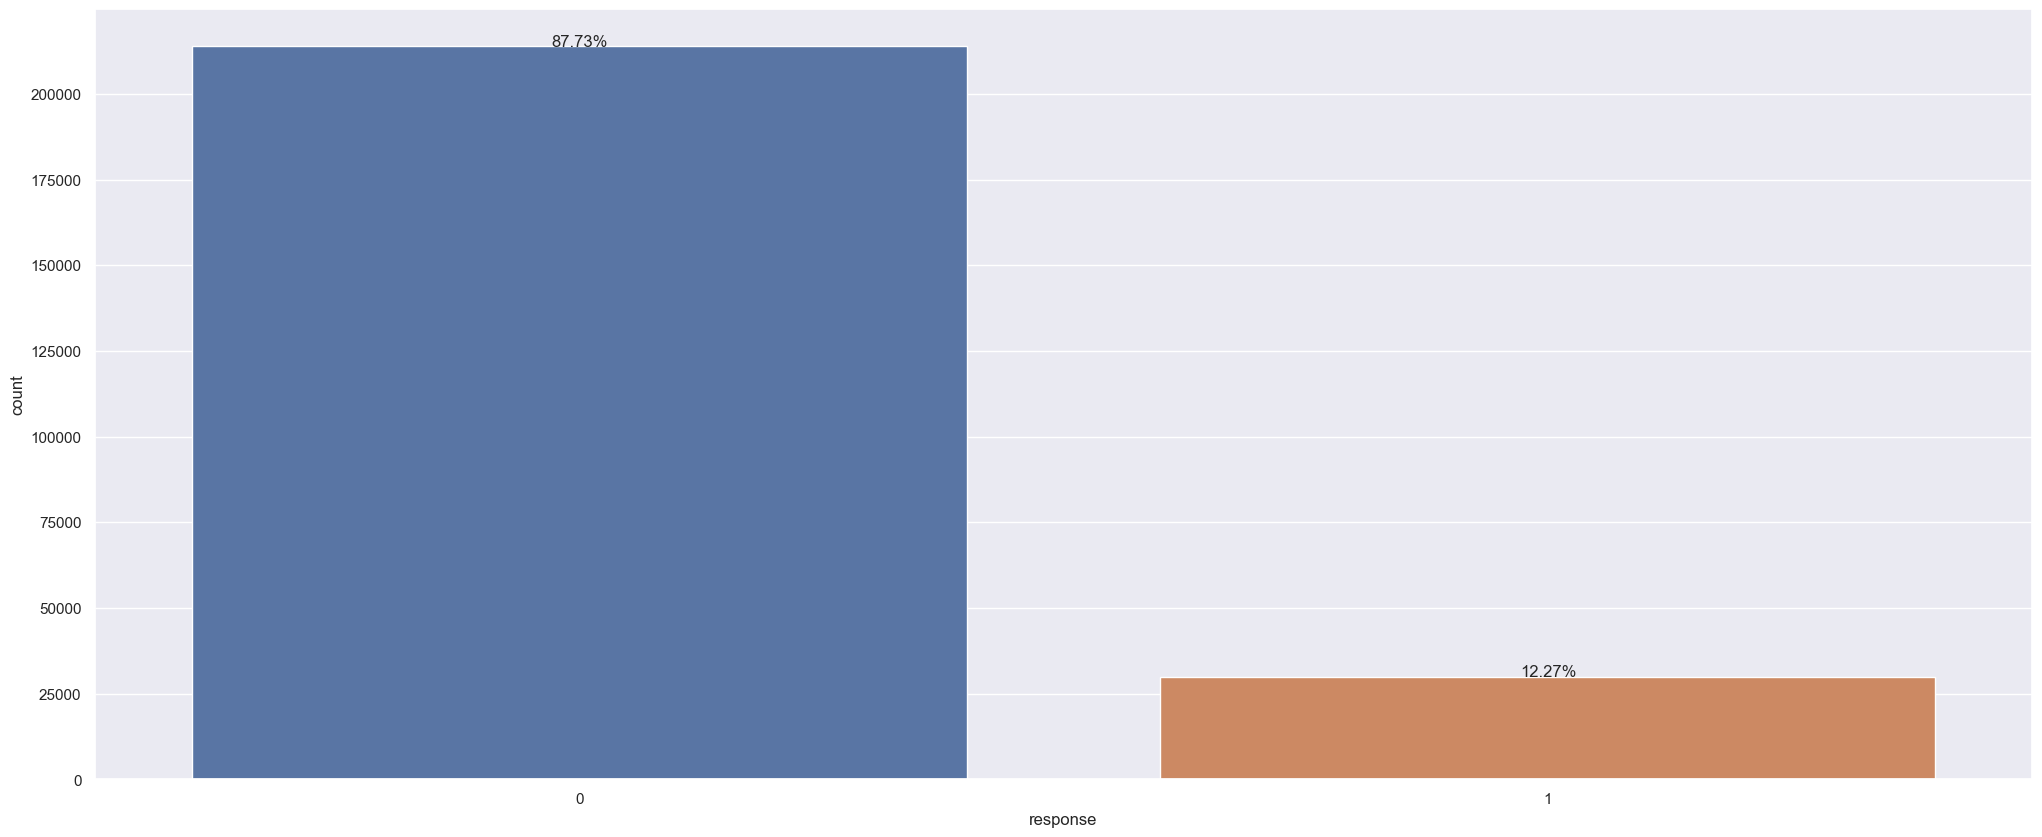

In [149]:
ax = sns.countplot(data=df4, x='response')
show_percentage(ax, df4)

### 4.1.1. Gender

Both genders show little interest in acquiring new insurance.

* Of the 45.81% female customers, 41% showed no interest in purchasing the product.
* Of the 54.19% male customers, 46.70% showed no interest in purchasing the product.

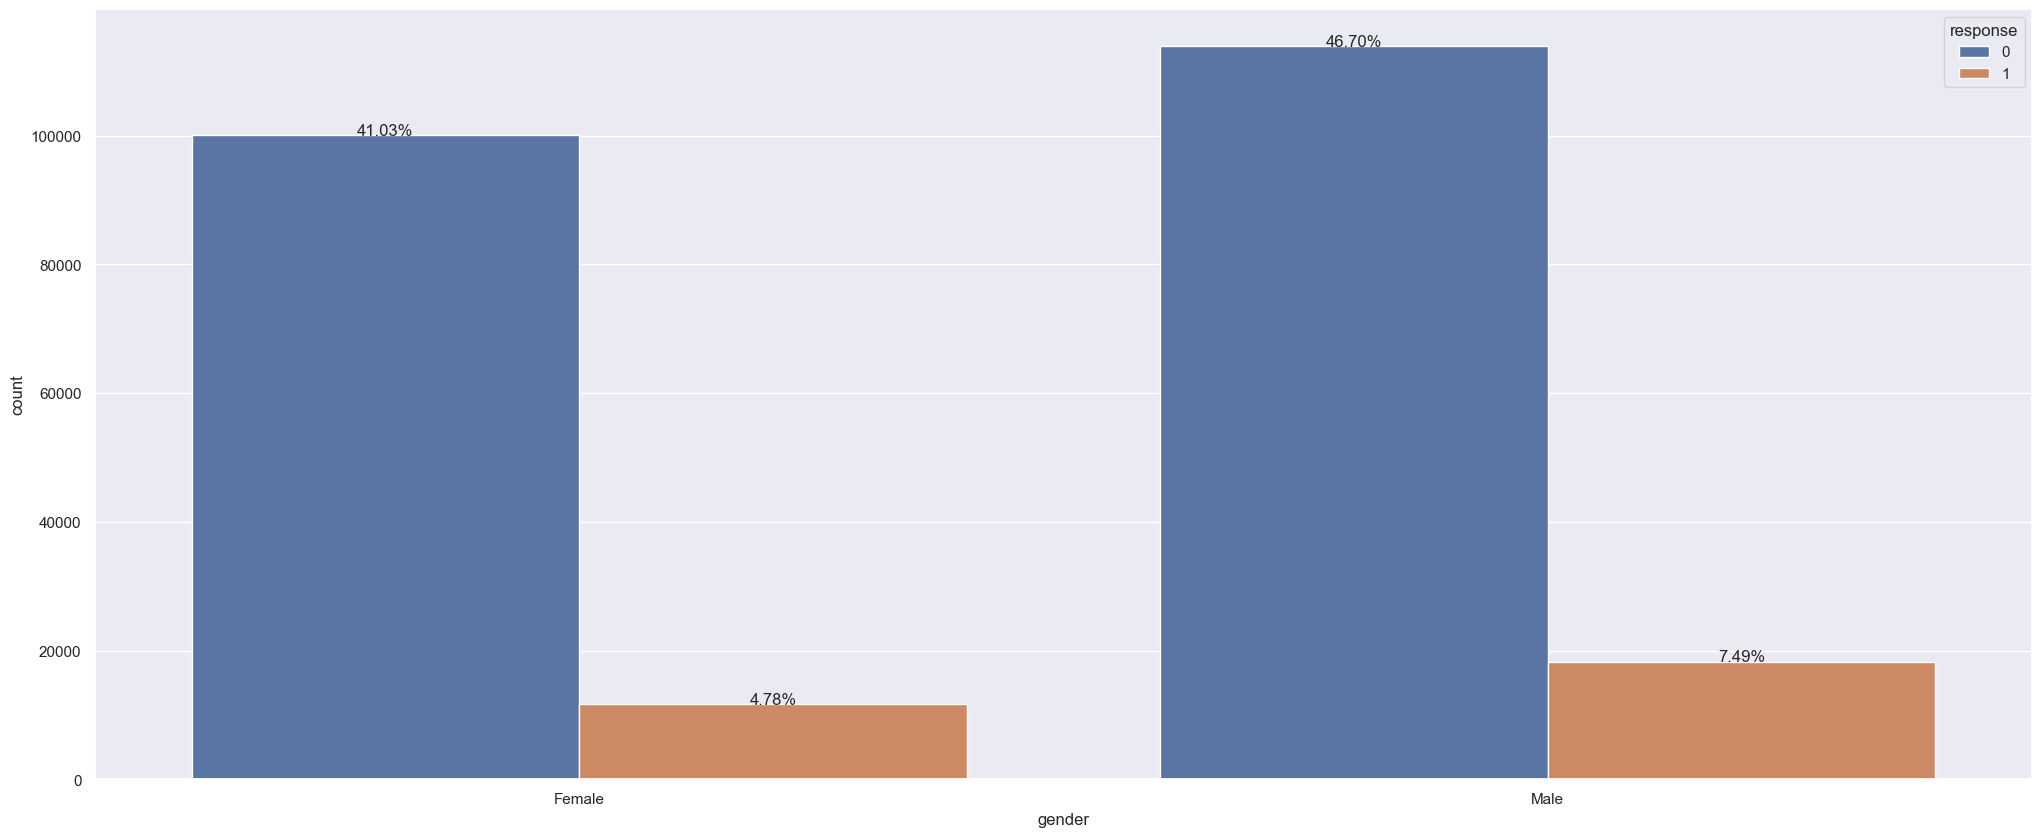

In [150]:
# Gender 
ax1 = sns.countplot(x = 'gender', hue = 'response', data = df1)
show_percentage(ax1, df1)

### 4.1.2. Age

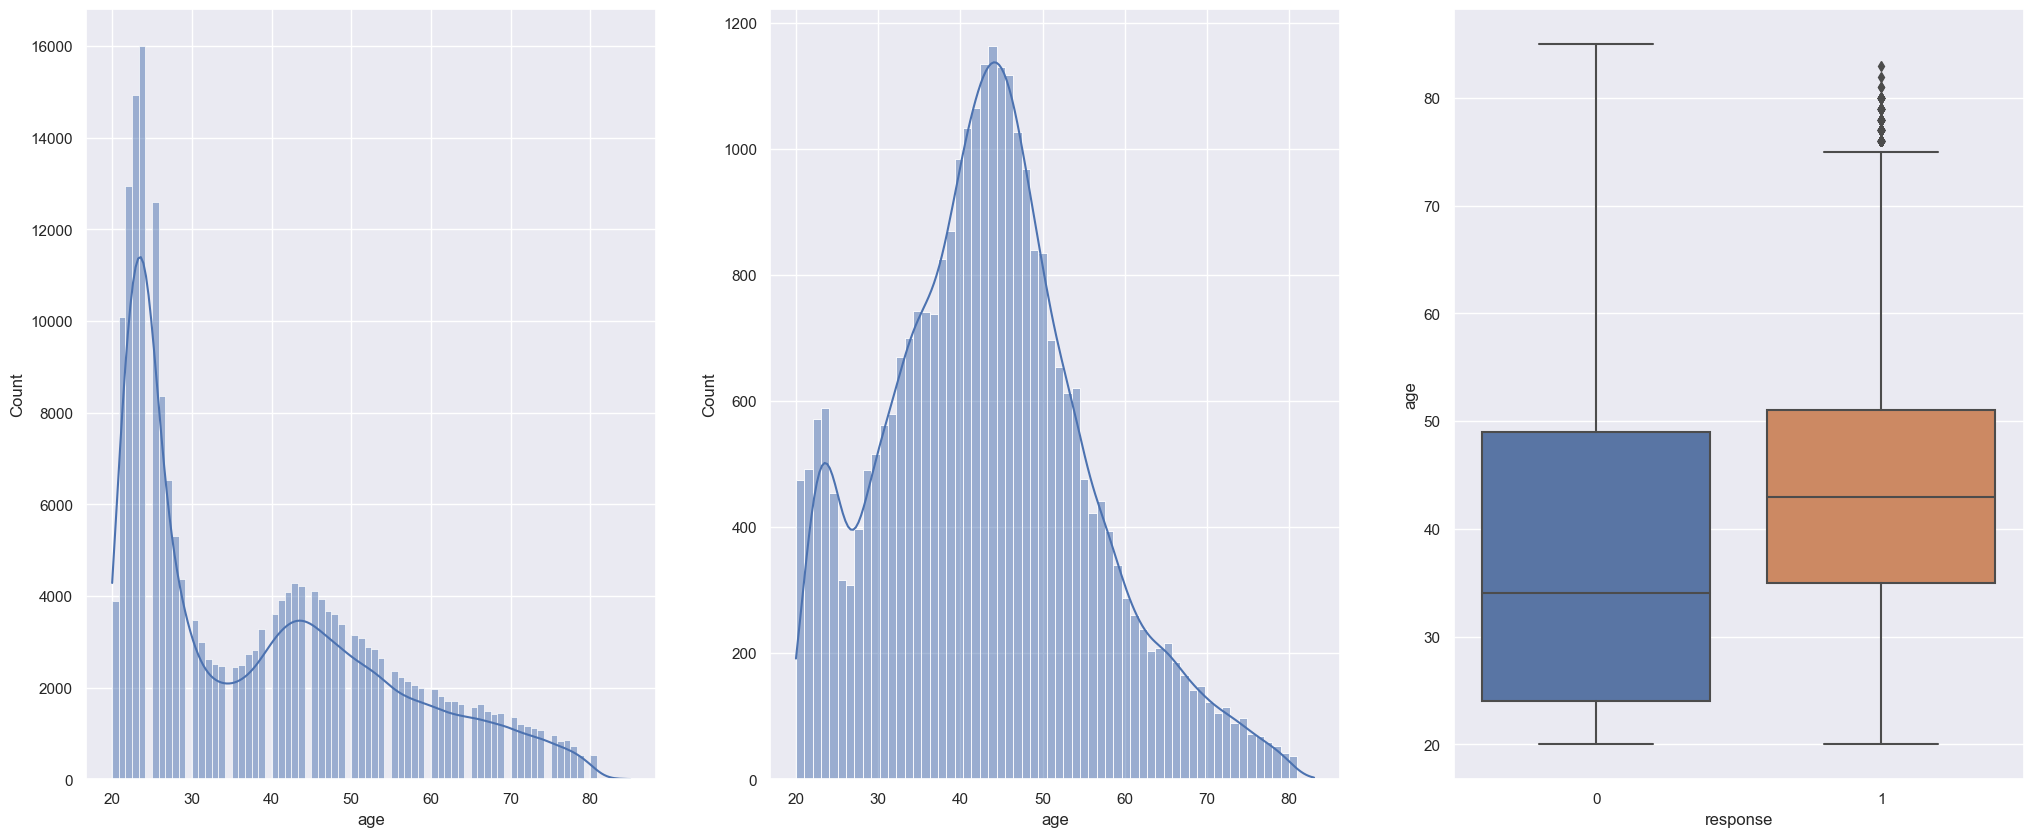

In [151]:
# Age
aux_0 = df4.loc[df4['response'] == 0, 'age']
aux_1 = df4.loc[df4['response'] == 1, 'age']

plt.subplot(1, 3, 1)
sns.histplot(aux_0, kde = True)

plt.subplot(1, 3, 2)
sns.histplot(aux_1, kde = True);

plt.subplot(1, 3, 3)
sns.boxplot(x = df4['response'], y = df4['age']);

### 4.1.3. Region Code

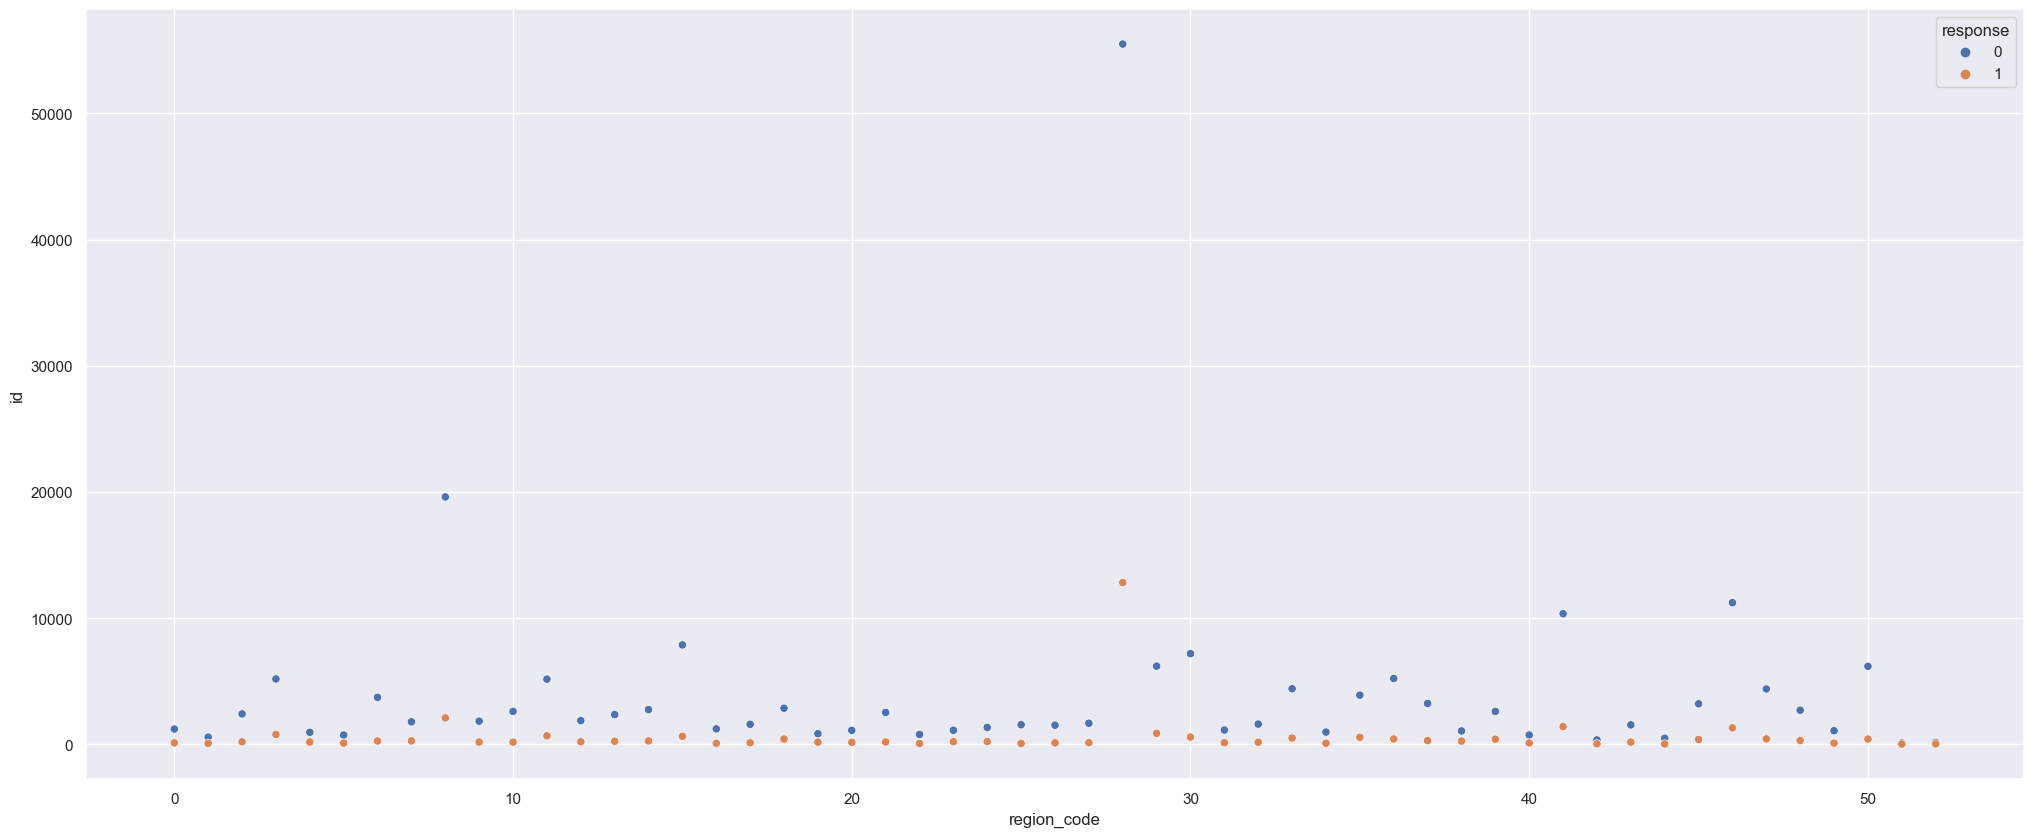

In [152]:
# region_code
aux = df4[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()

sns.scatterplot(x = 'region_code', y='id', hue='response', data= aux);

### 4.1.4. Policy Sales Channel

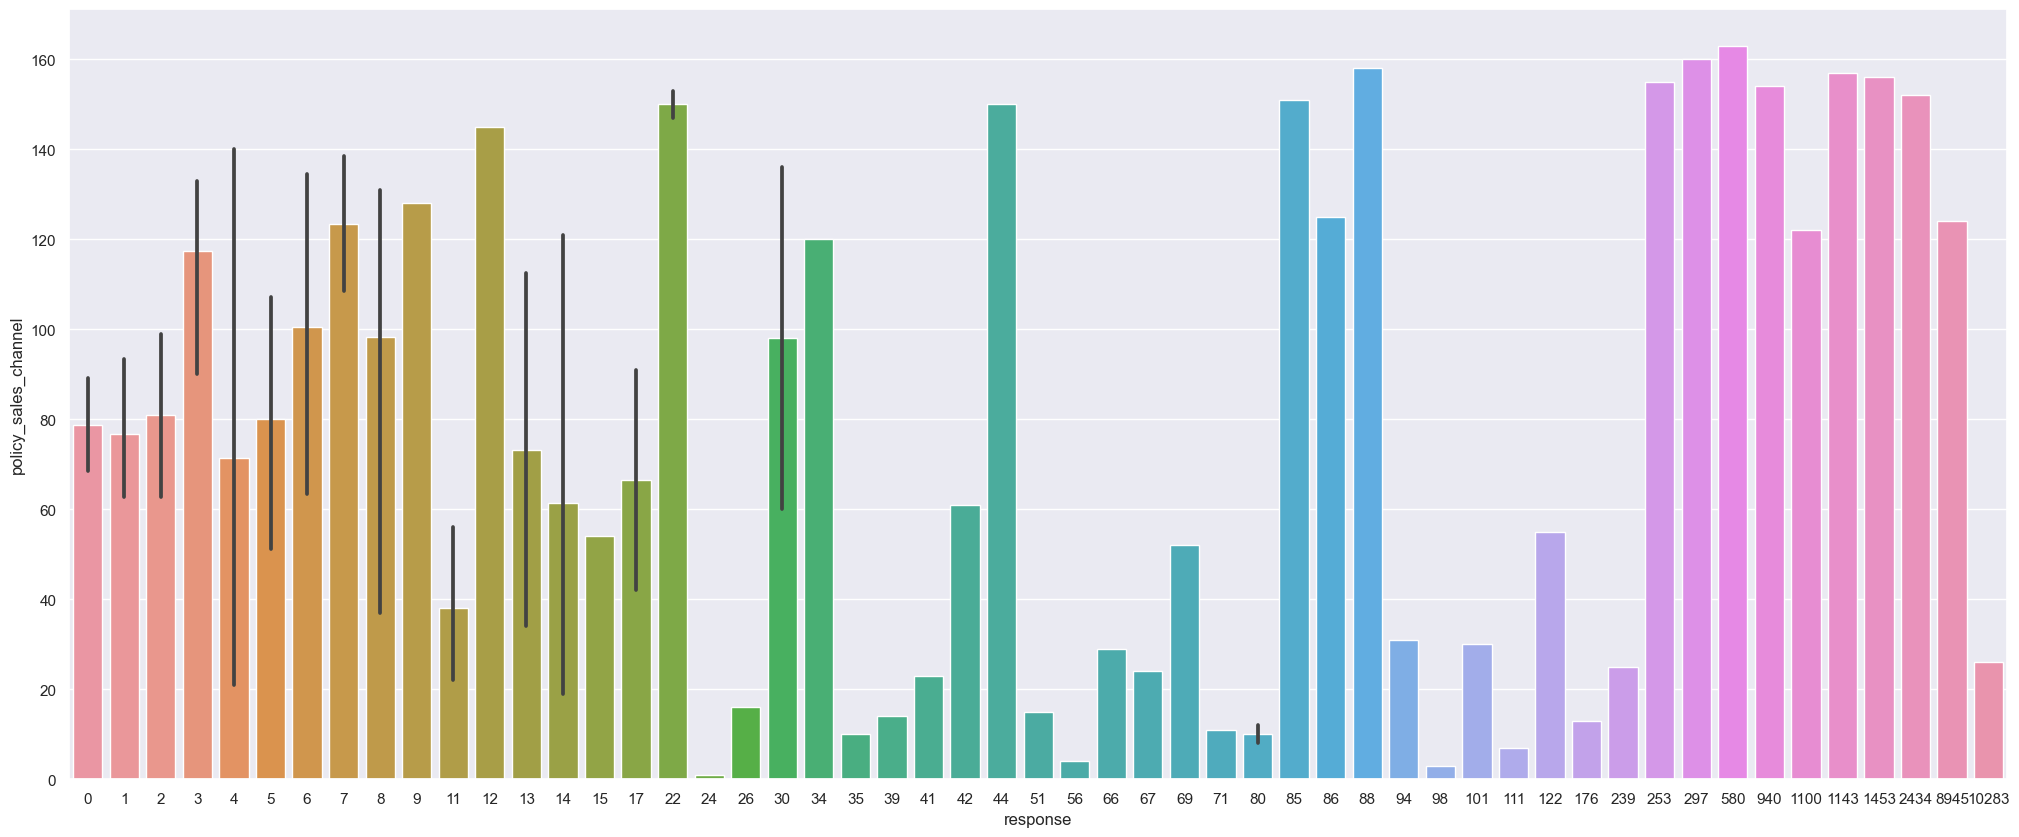

In [153]:
# policy_sales_channel

aux = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()

sns.barplot(x= 'response', y ='policy_sales_channel', data = aux);

### 4.1.5. Driving License

* Here we can see that people with driving license have more interest in purchasing the product

In [154]:
dl = pd.crosstab(df4['driving_license'], df4['response']).apply(lambda x: x / x.sum(), axis = 1)
dl

response,0,1
driving_license,,
0,0.950943,0.049057
1,0.877142,0.122858


### 4.1.6. Vehicle Age

* Clients with car between 1-2 year have more interest in purchasing the product.

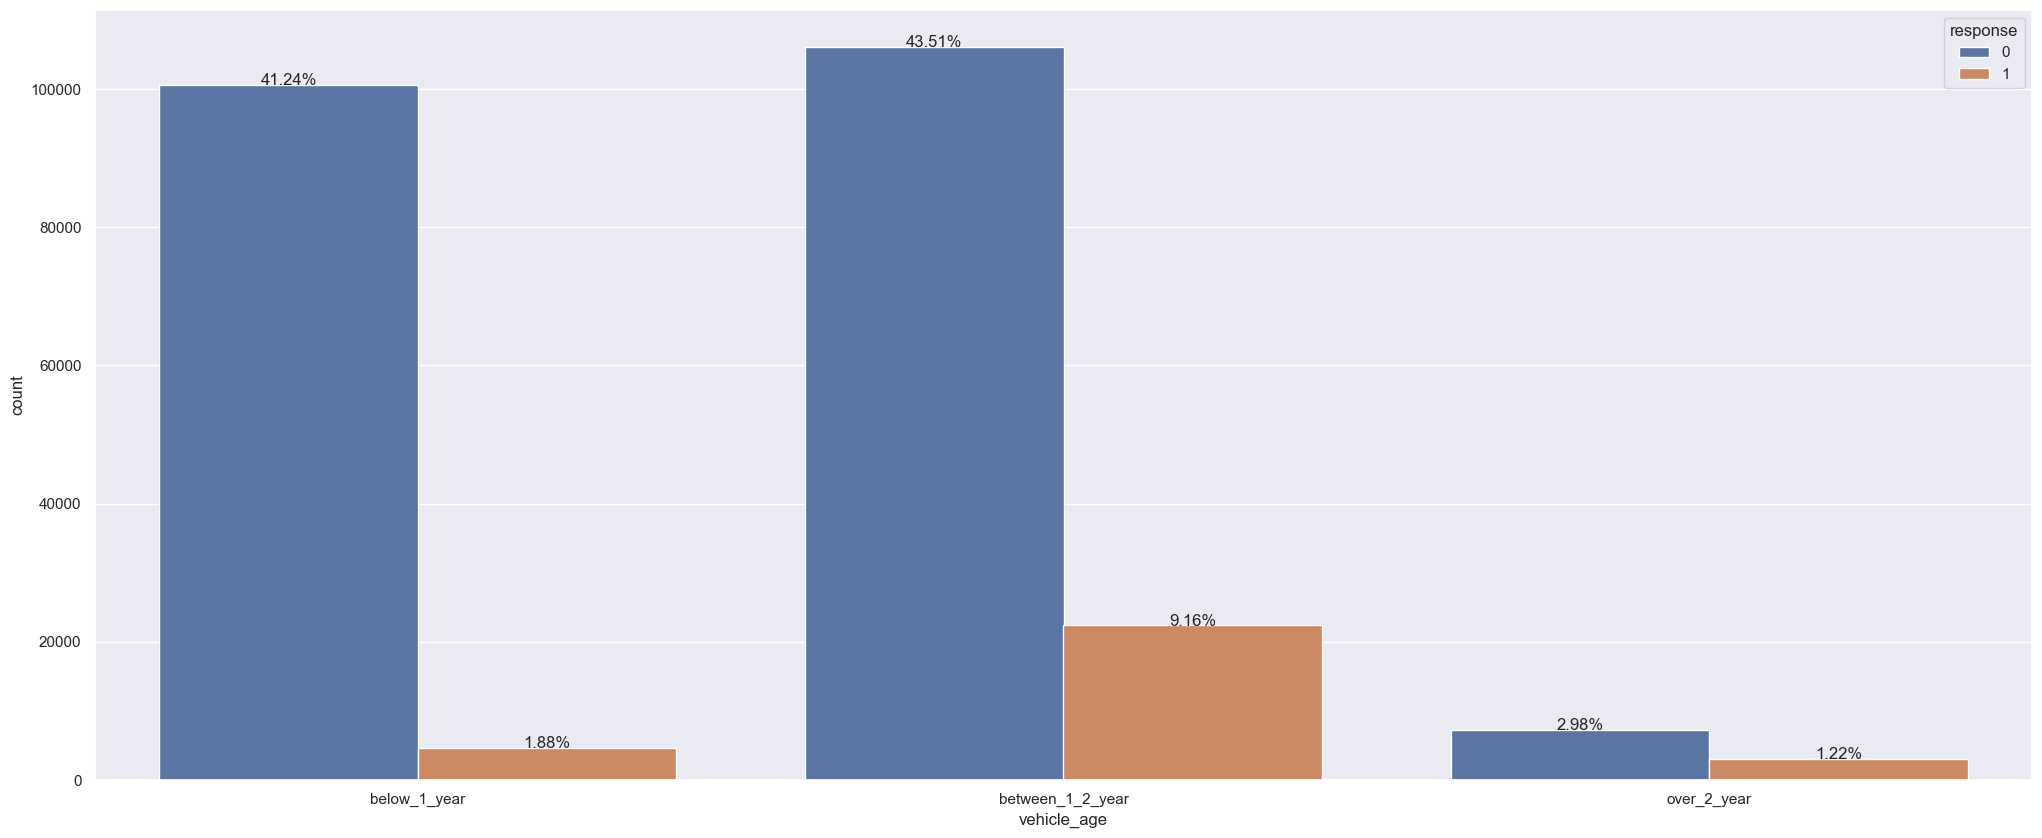

In [155]:

ax = sns.countplot(x = 'vehicle_age', hue = 'response',  data = df4)
show_percentage(ax, df4)

### 4.1.7. Vehicle Damage

* Customers who have already had their vehicle damaged are more likely to purchase the new insurance.

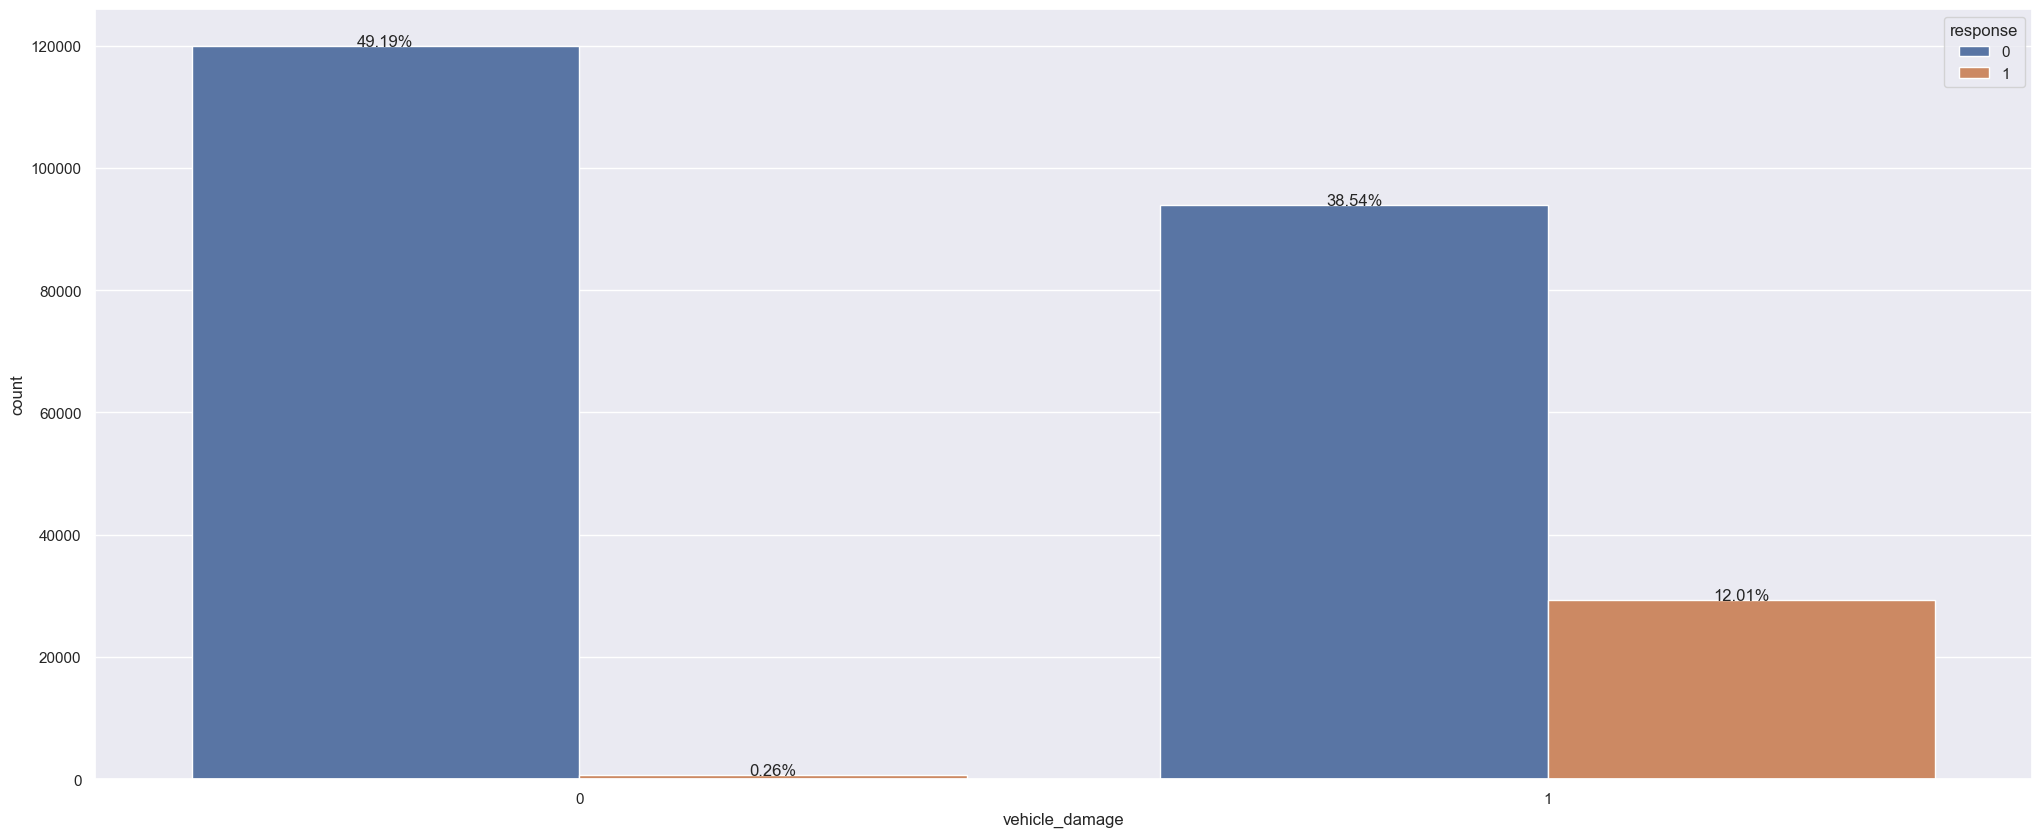

In [156]:
# Vehicle Damage
ax = sns.countplot(x = 'vehicle_damage', hue = 'response',  data = df4)
show_percentage(ax, df4);

### 4.1.8. Previously Insured

* Customers who don't have any insurance are more likely to buy the new one than customers who already have an insurance.

In [157]:
# previously_insured

# pode ser um vazamento de dados por conta dos 0.99%

pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: x / x.sum(), axis = 1)

response,0,1
previously_insured,,
0,0.774084,0.225916
1,0.999124,0.000876


### 4.1.9. Annual Premium

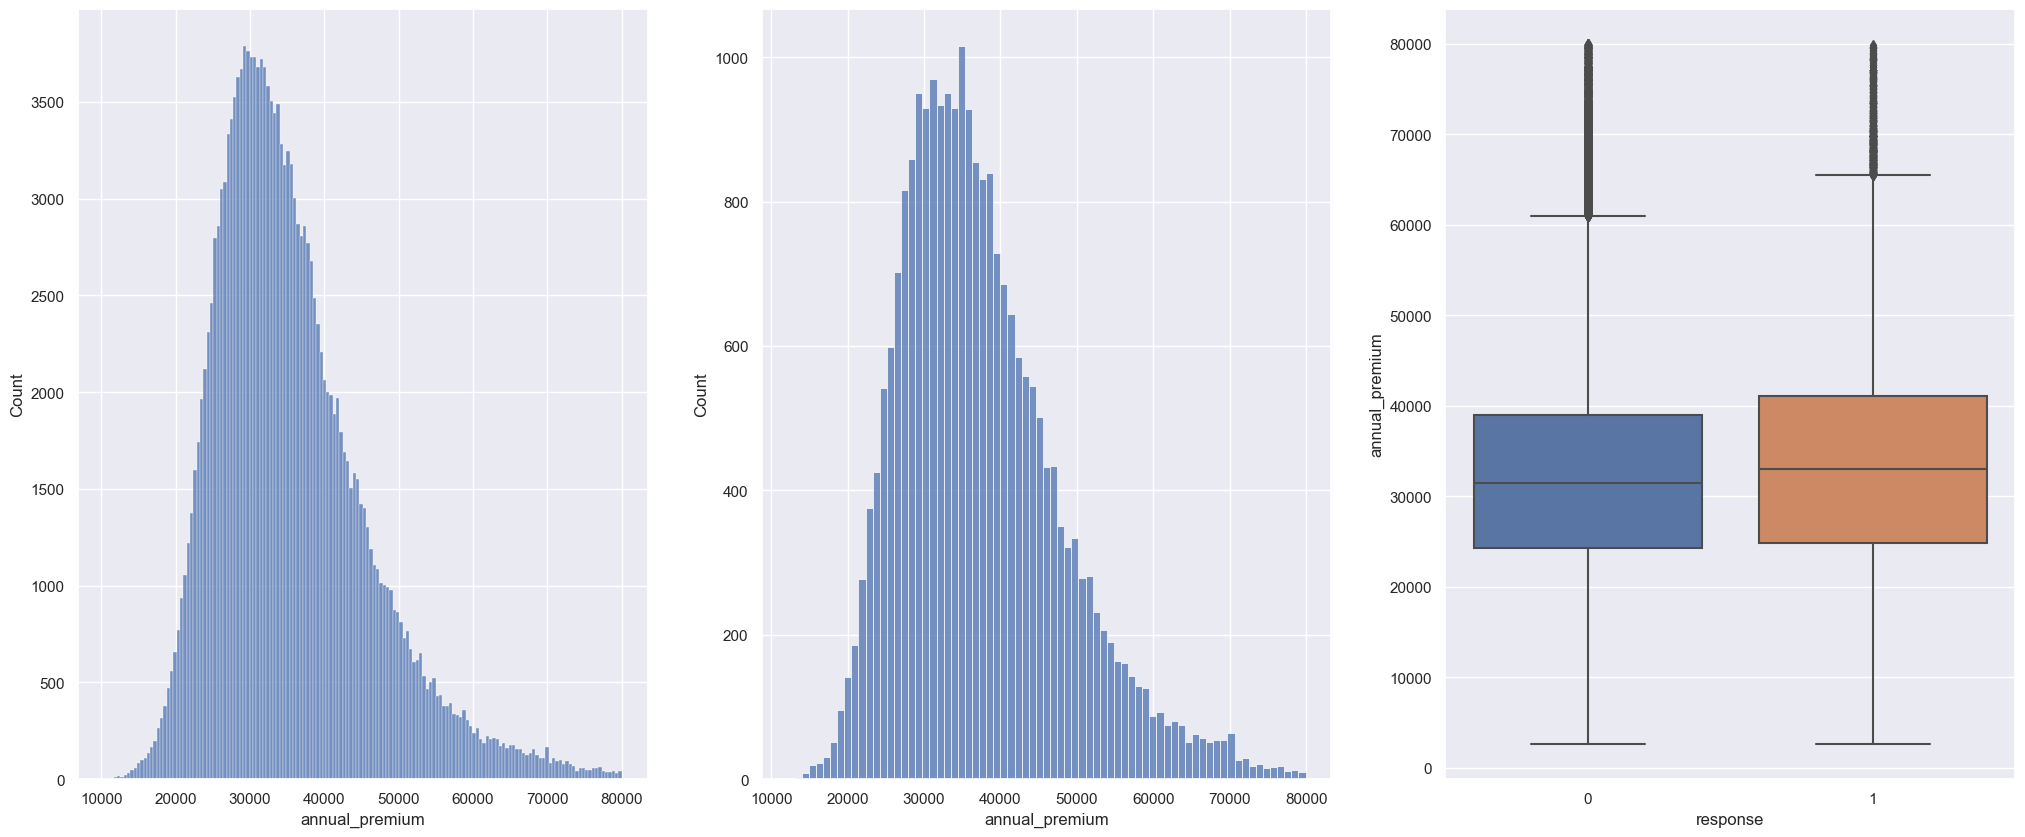

In [158]:
# annual_premium
aux = df4[df4['annual_premium'] < 80000]

# medianas iguais, se verificarmos a distribuição, provavelmente vai estar igual ou muito parecida
plt.subplot(1, 3, 1)

aux2 = aux.loc[ (aux['response'] == 0) & (df4['annual_premium'] > 10000), 'annual_premium']
sns.histplot(aux2)

# distribuition
plt.subplot(1, 3, 2)

aux3 = aux.loc[(aux['response'] == 1) & (df4['annual_premium'] > 10000), 'annual_premium']
sns.histplot(aux3);

plt.subplot(1, 3, 3)

sns.boxplot(data = aux, x = 'response', y = 'annual_premium');


### 4.1.10. Vintage

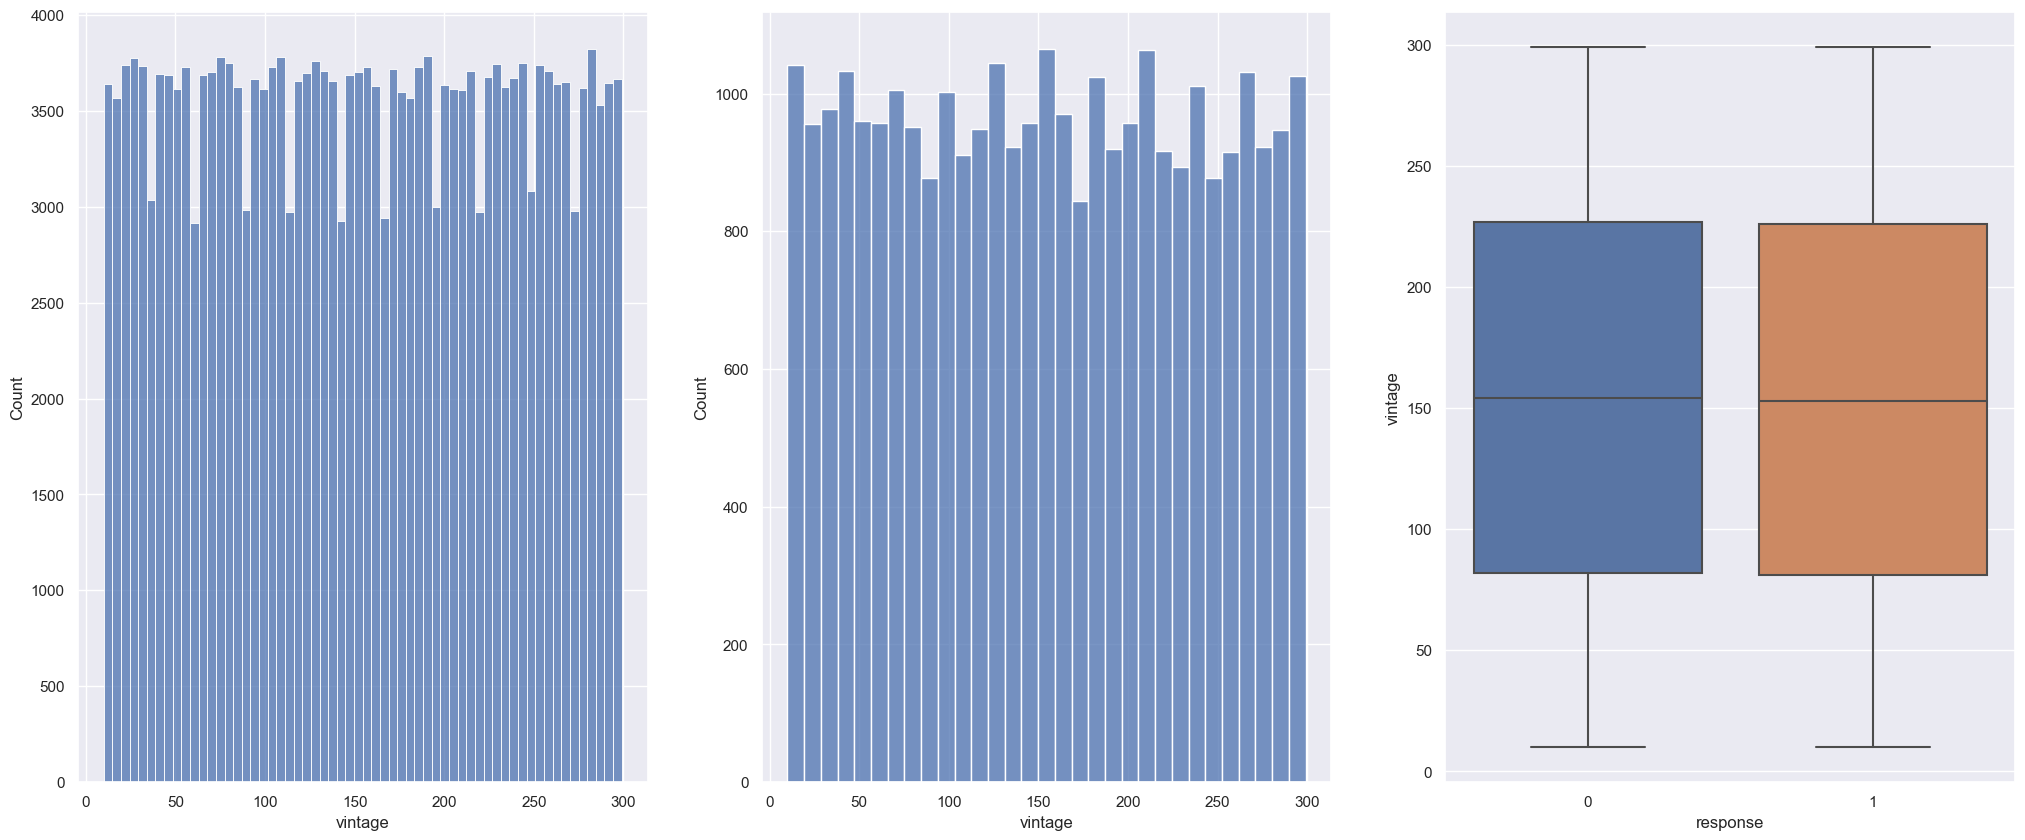

In [159]:
# vintage

aux = df4.loc[df4['response'] == 0, 'vintage']
aux2 = df4.loc[df4['response'] == 1, 'vintage']

plt.subplot(1, 3, 1)
sns.histplot(aux)

plt.subplot(1, 3, 2)
sns.histplot(aux2)

plt.subplot(1, 3, 3)
sns.boxplot(data = df4, x = 'response', y = 'vintage');

## 4.2. Bivariate Analysis

### 4.2.1. H1 - Customers with a driver's license are more likely to purchase a new insurance policy.

**True:** Customers with a driver's license have a more interest in purchasing the product.

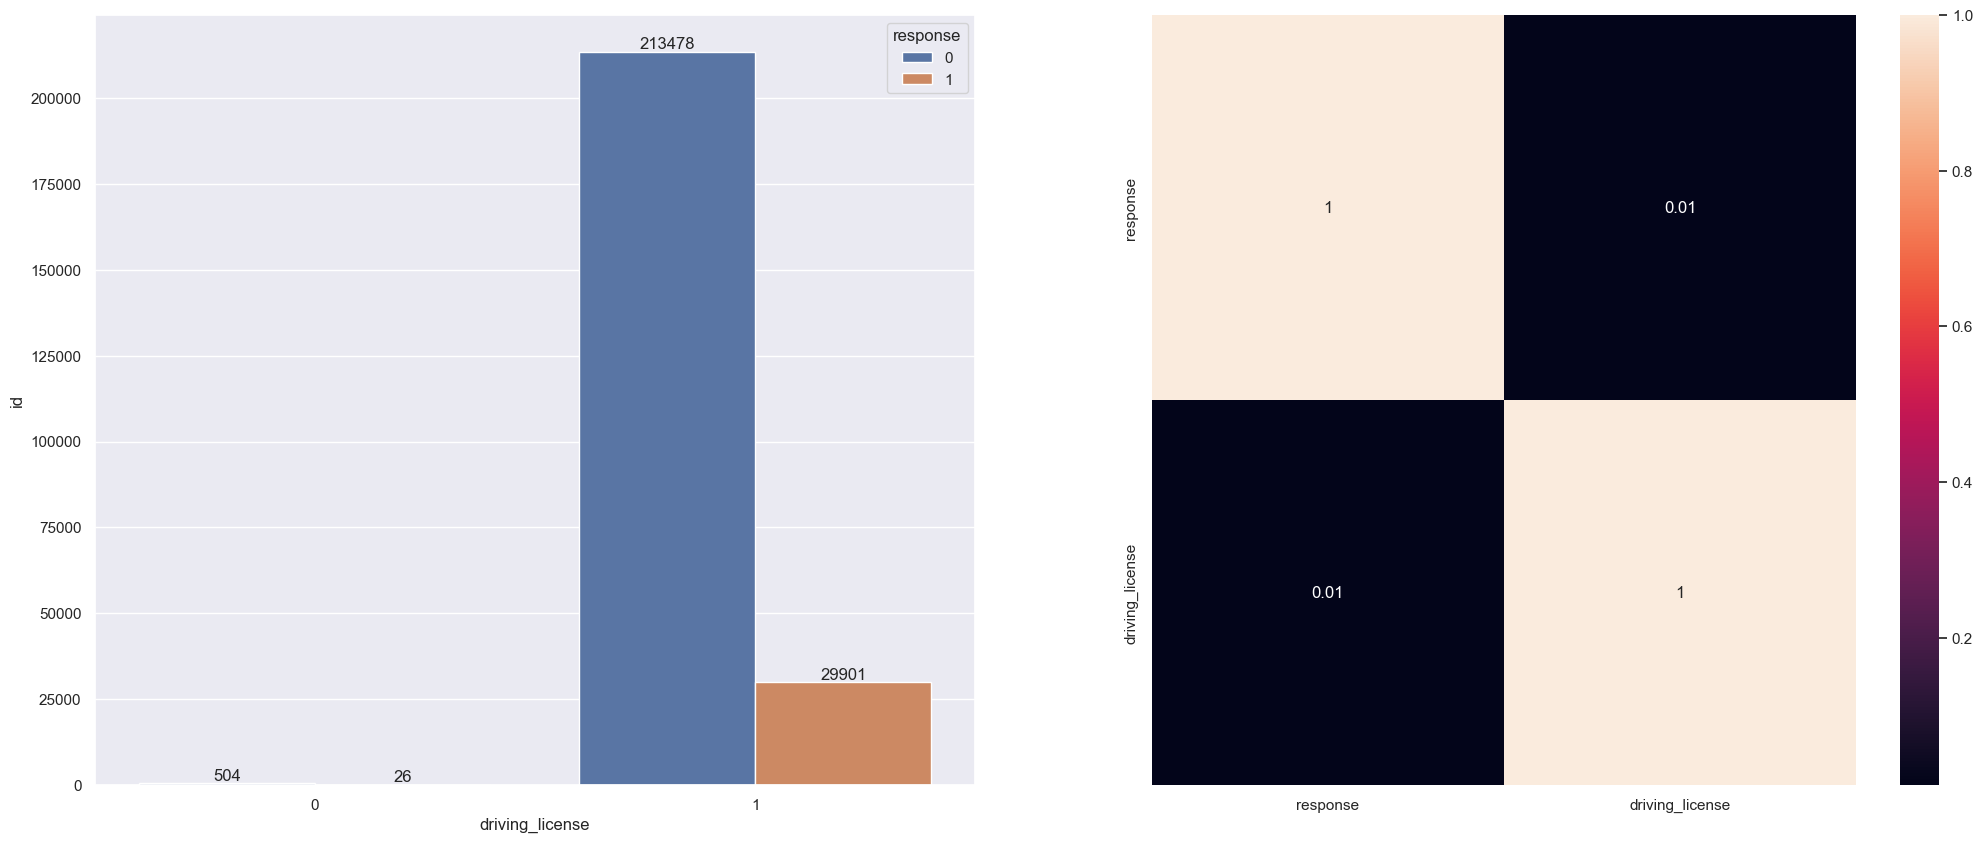

In [160]:
h1 = df4[['id', 'driving_license', 'response']].groupby(['driving_license', 'response']).count().reset_index()

plt.subplot(1, 2, 1)
ax = sns.barplot(x='driving_license', y='id', hue='response',  data=h1)
ax.bar_label(ax.containers[0]);
ax.bar_label(ax.containers[1]);

plt.subplot(1, 2, 2)

sns.heatmap(df4[['response', 'driving_license']].corr(method='pearson'), annot=True);

### 4.2.2. H2 - Customers above 35 years old are more likely to purchase a new insurance policy.

**True:** The age of customers most likely to purchase a new insurance policy ranges from 35 to 50 years, with its peak at 44 years.

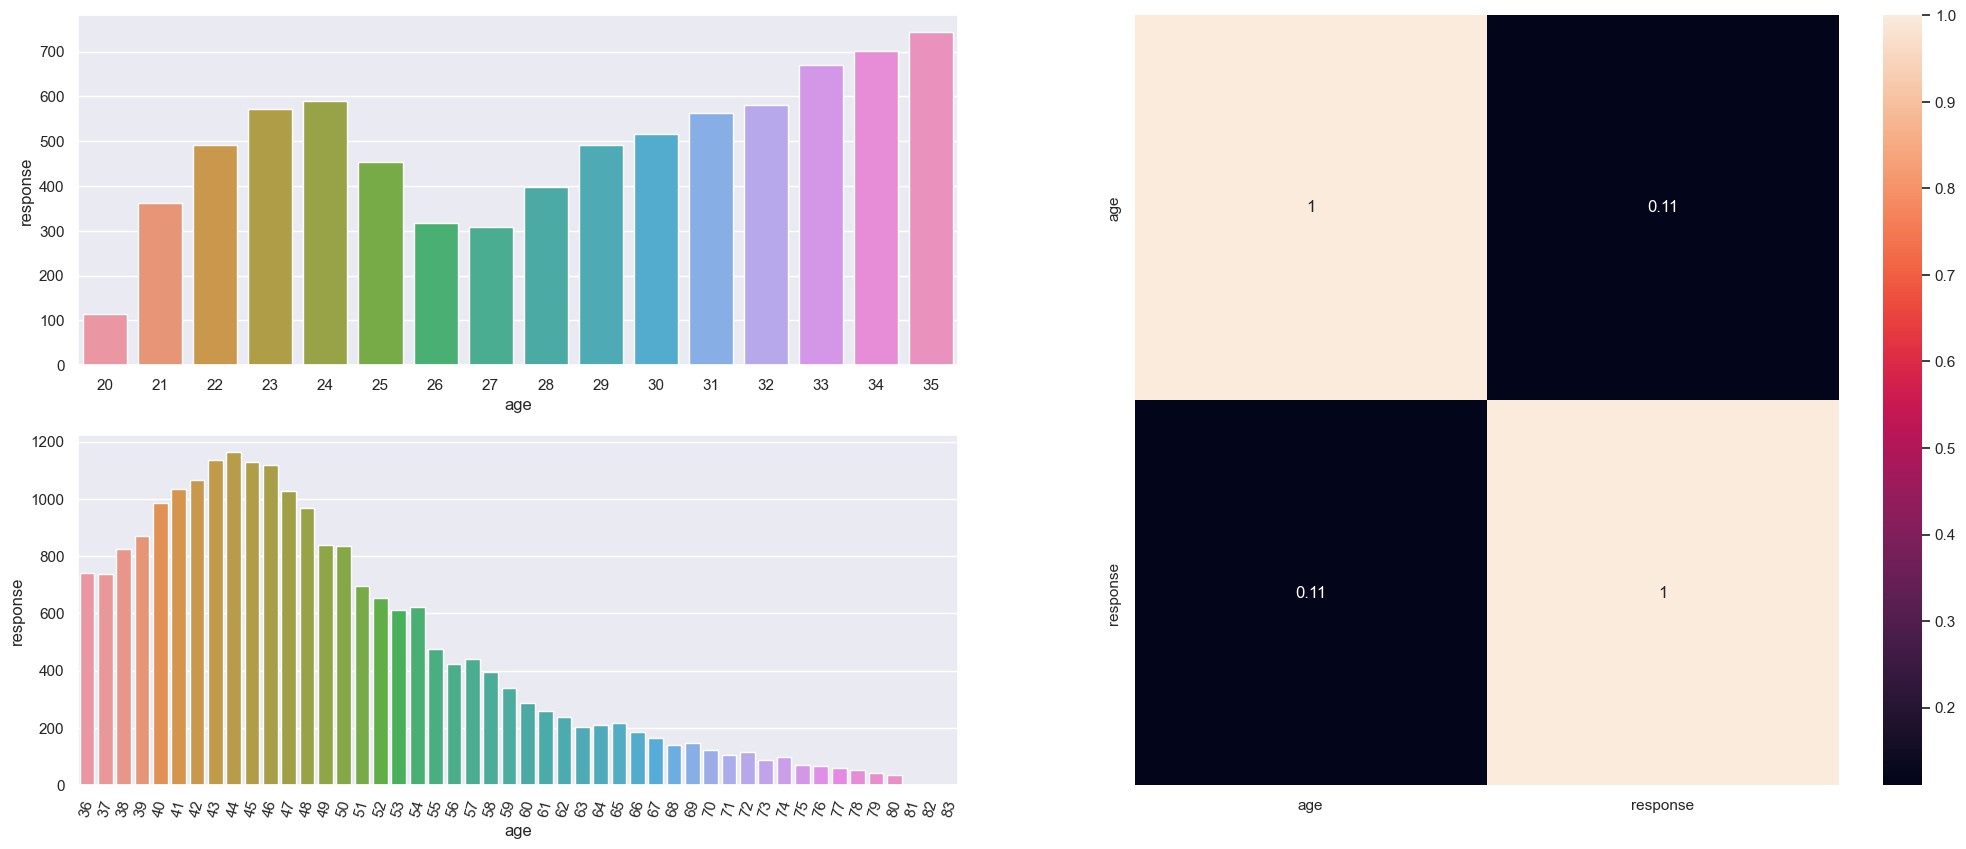

In [161]:
grid = gridspec.GridSpec(2,2)

plt.subplot(grid[0,0])
aux = df4.loc[(df4['age'] <= 35) & (df4['response'] == 1), :]
aux = aux[['age', 'response']].groupby('age').count().reset_index()

sns.barplot(data = aux, x = 'age' , y = 'response')


plt.subplot(grid[1,0])
aux1 = df4.loc[(df4['age'] > 35) & (df4['response'] == 1), :]
aux1 = aux1[['age', 'response']].groupby('age').count().reset_index()

sns.barplot(data = aux1, x = 'age' , y = 'response')
plt.xticks(rotation=75);

plt.subplot(grid[:, 1])
sns.heatmap(df4[['age', 'response']].corr(method='pearson'), annot=True);

### 4.2.3. H3 - Female customers are more likely to purchase a second insurance policy.

**False:** Female customers are more likely to purchase a second insurance policy.

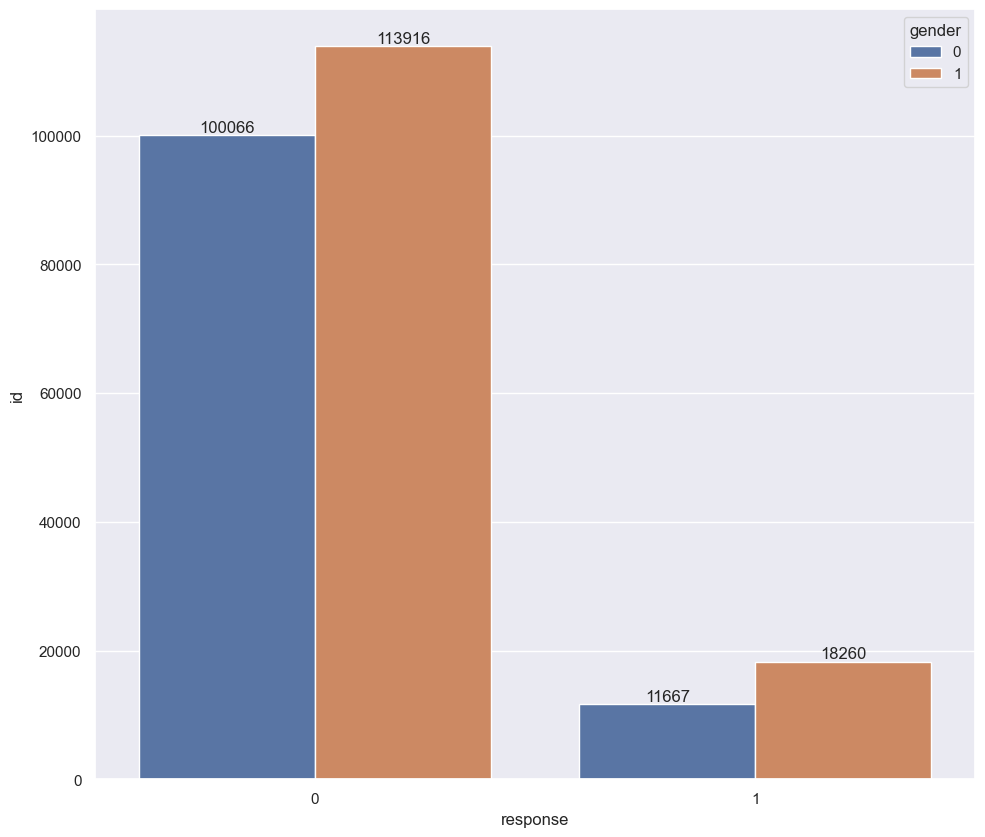

In [162]:
h3 = df4[['gender', 'response', 'id']].groupby(['gender', 'response']).count().reset_index()

plt.subplot(1, 2, 1)
ax = sns.barplot(data= h3, x = 'response', y='id', hue = 'gender')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1]);

### 4.2.4. H4 - Customers who have been with us for a longer period of time are more likely to purchase a new insurance policy.

**False:** There is no difference.

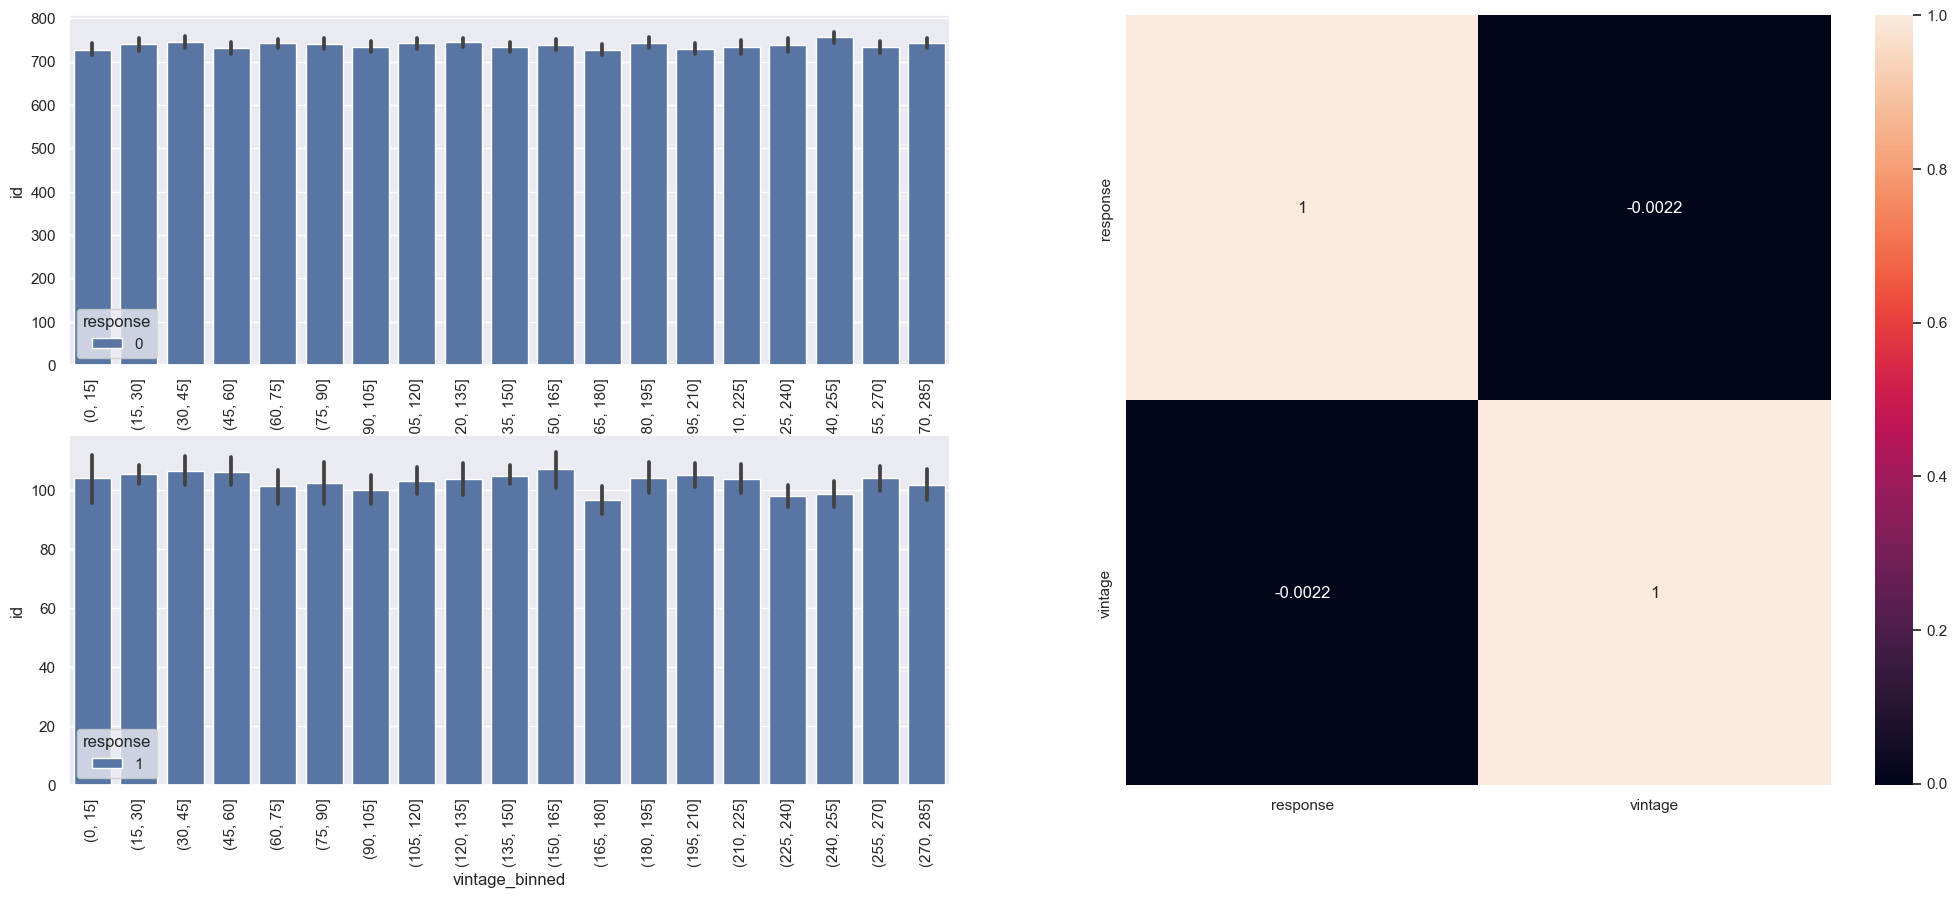

In [163]:
grid = gridspec.GridSpec(2,2)

aux1 = df4.loc[df4['response'] == 0, :]
aux1 = aux1[['id', 'response', 'vintage']].groupby(['vintage', 'response']).count().reset_index()

plt.subplot( grid[0,0] )
bins = list( np.arange( 0, 300, 15) )
aux1['vintage_binned'] = pd.cut( aux1['vintage'], bins=bins )

sns.barplot(data = aux1, x = 'vintage_binned', y='id', hue='response')
plt.xticks(rotation=90)


plt.subplot( grid[1,0] )
aux2 = df4.loc[df4['response'] == 1, :]
aux2 = aux2[['id', 'response', 'vintage']].groupby(['vintage', 'response']).count().reset_index()
plt.xticks(rotation=90)


aux2['vintage_binned'] = pd.cut( aux2['vintage'], bins=bins )

sns.barplot(data = aux2, x = 'vintage_binned', y='id', hue='response');

plt.subplot( grid[:,1] )
x = sns.heatmap( df4[['response', 'vintage']].corr( method='pearson'), annot=True );

### 4.2.5. H5 - The likelihood of purchasing a second insurance policy is higher for customers who have already acquired another policy previously.

**False:** Customers who have never purchased an insurance policy are more likely to acquire a new one compared to those who are already insured.

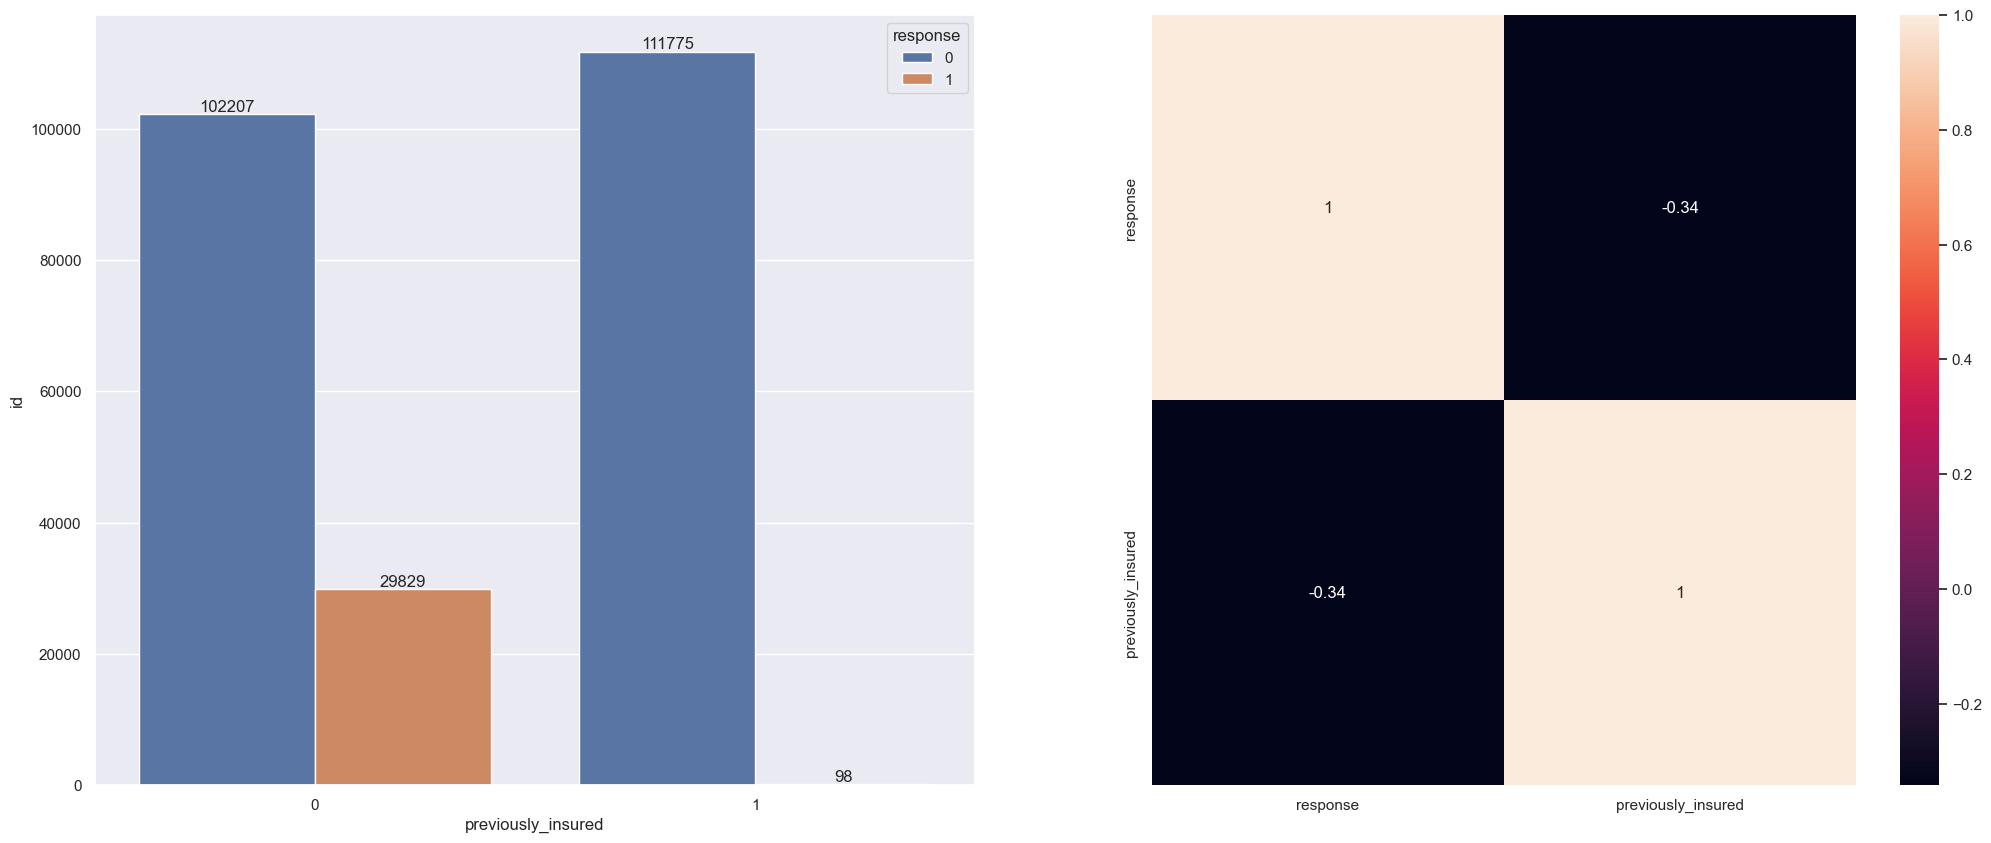

In [164]:
h5 = df4[['id', 'response', 'previously_insured']].groupby(['response', 'previously_insured']).count().reset_index()

plt.subplot(1, 2, 1)
ax = sns.barplot(data = h5, x='previously_insured', y='id', hue='response')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])



plt.subplot(1, 2, 2)
sns.heatmap(df4[['response', 'previously_insured']].corr(method='pearson'), annot = True);

### 4.2.6. H6 - Customers who have owned a vehicle for more than two years are more likely to acquire a new insurance policy.

**False:** Customers who have owned a car for more than two years are the least likely to acquire a new insurance policy.

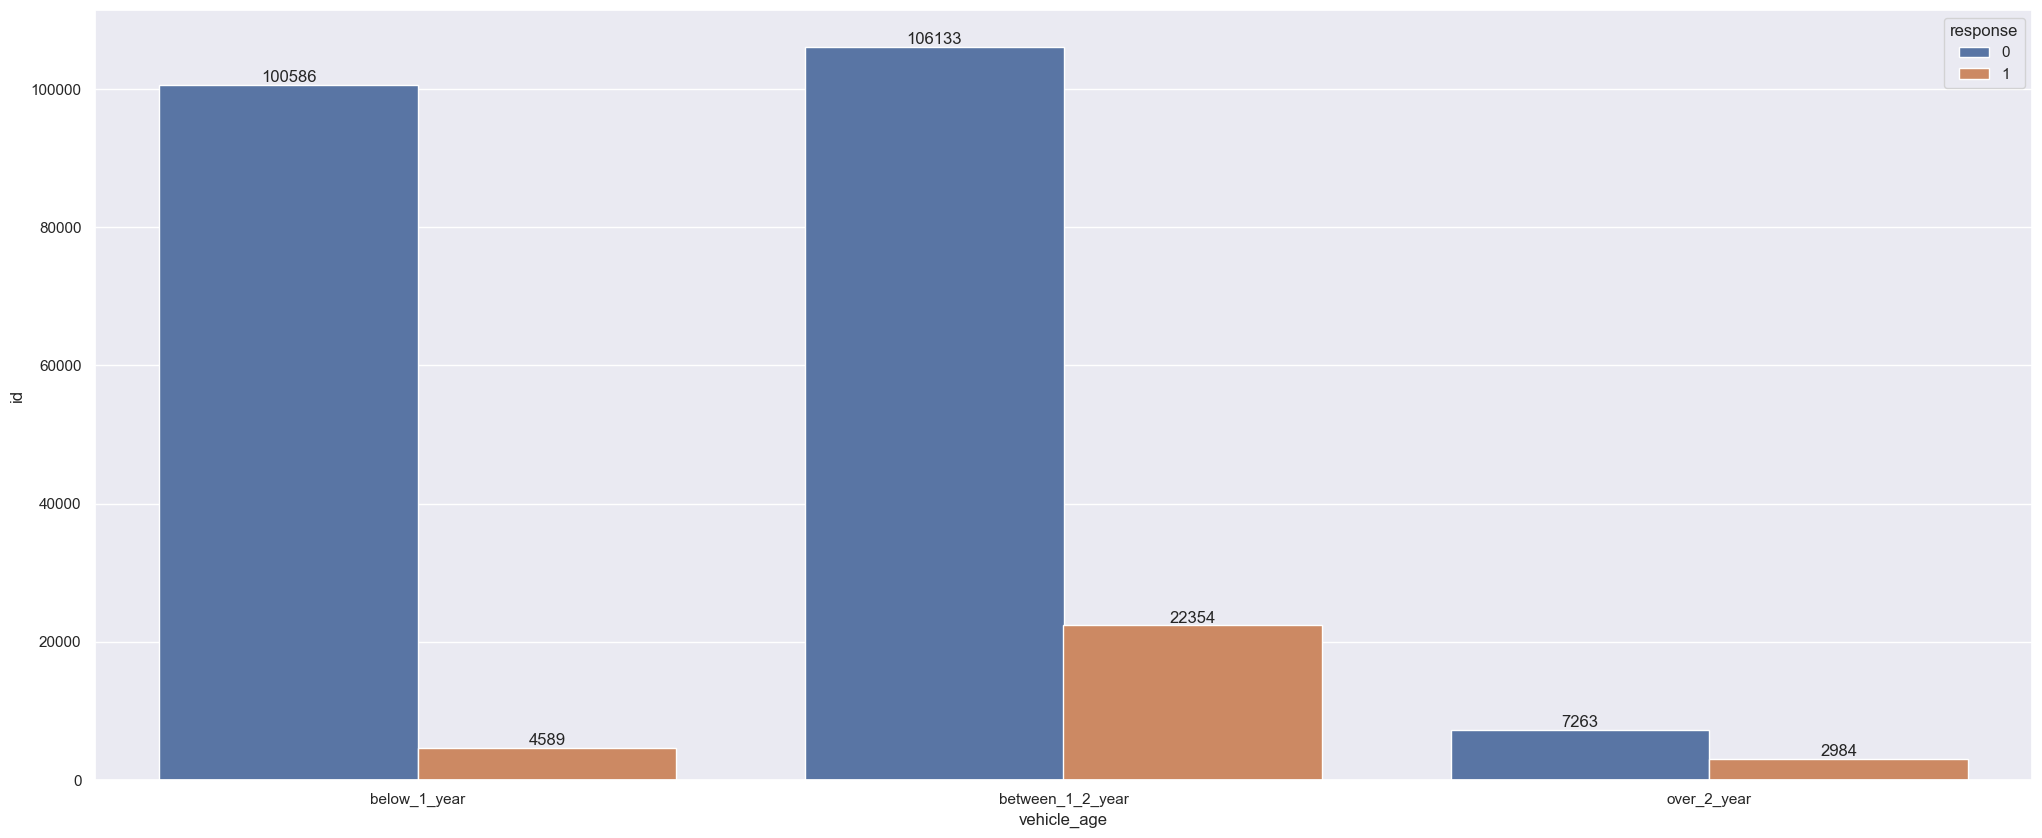

In [165]:
h6 = df4[['id', 'vehicle_age', 'response']].groupby(['response', 'vehicle_age']).count().reset_index()

ax = sns.barplot(data=h6, x='vehicle_age', y='id', hue='response')
ax.bar_label(ax.containers[0]);
ax.bar_label(ax.containers[1]);

###  4.2.7. H7 Customers with an annual premium above 50000 are more likely to acquire a new insurance policy.

**False:** There is no variation in the results that indicates a higher or lower probability depending on the amount of the annual premium.

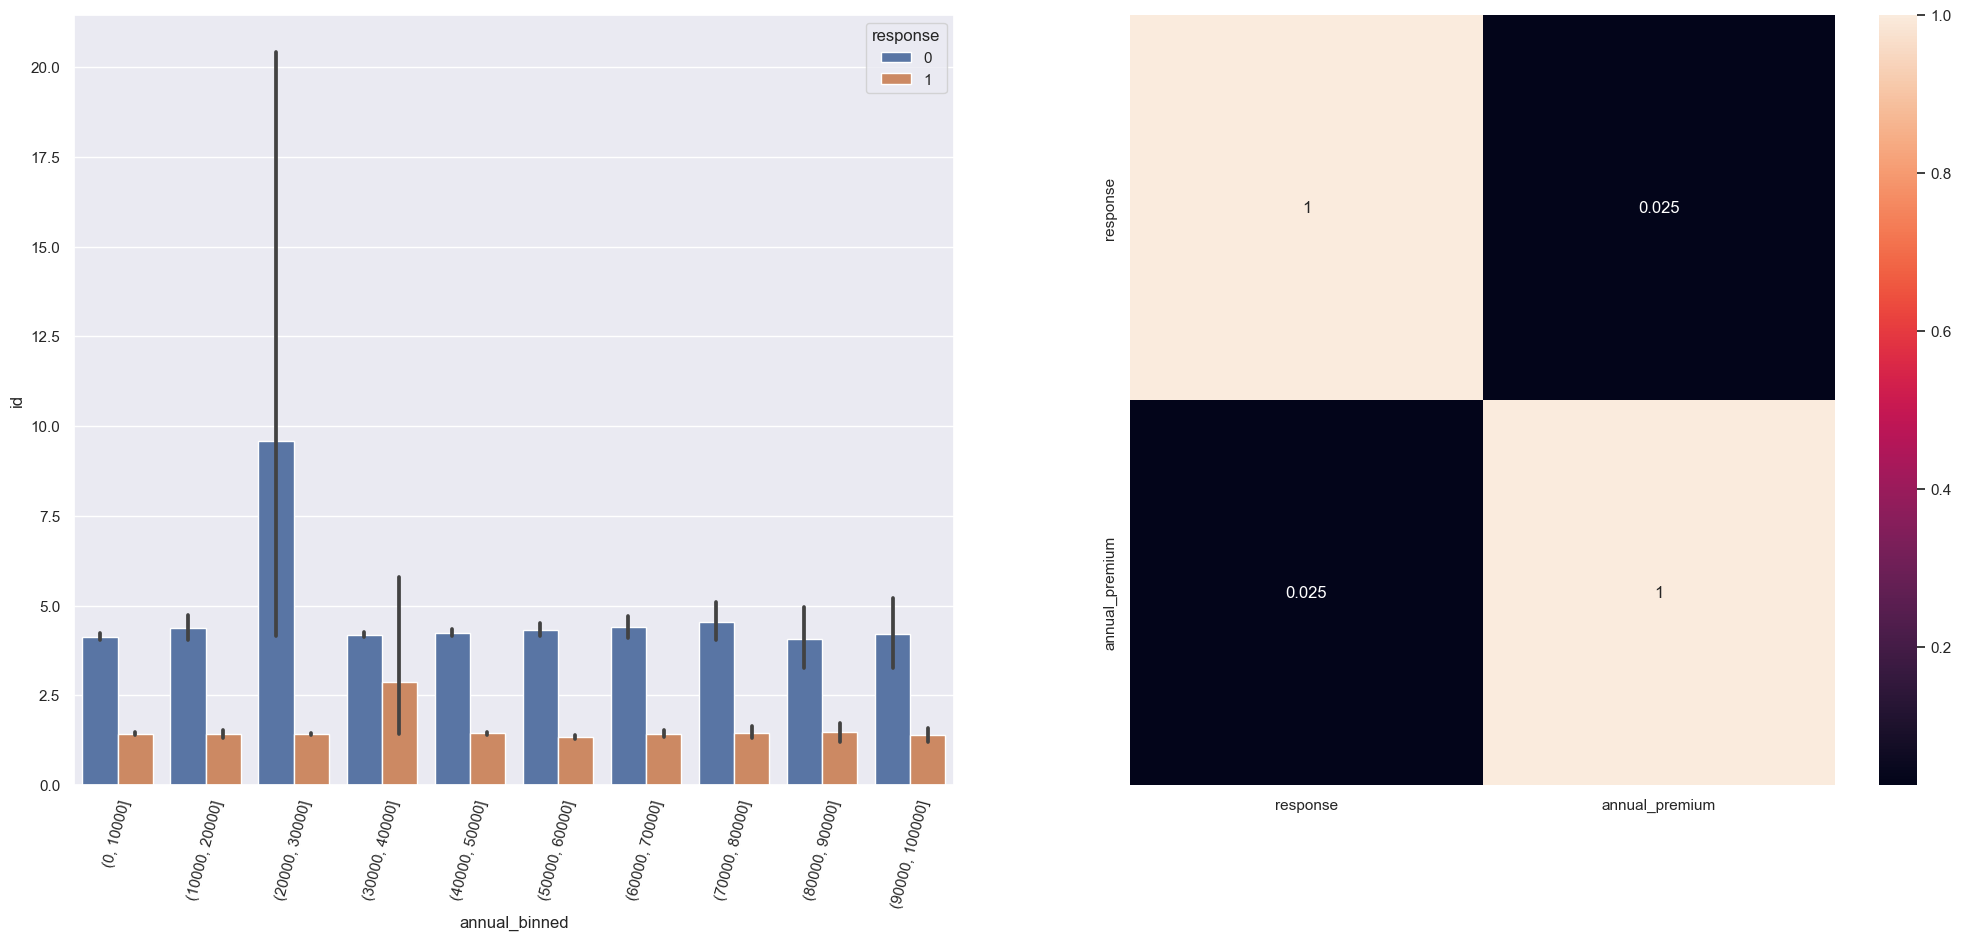

In [166]:
bins = list( np.arange( 0, 110000, 10000) )
aux = df4[['id', 'annual_premium', 'response']]
aux = aux[['id', 'annual_premium', 'response']].groupby(['annual_premium', 'response']).count().reset_index()
aux['annual_binned'] = pd.cut(df4['annual_premium'], bins=bins)

aux[['annual_premium', 'response']].groupby(['annual_premium', 'response']).mean().reset_index()

plt.subplot(1, 2, 1)
ax = sns.barplot(data = aux, x='annual_binned', y='id', hue='response')


plt.xticks(rotation=75)

plt.subplot(1, 2, 2)
sns.heatmap(df4[['response', 'annual_premium']].corr(method='pearson'), annot=True);

### 4.2.8. H8 The lower the customer's region code, the more likely they are to make a purchase.

**False:** There is no clear trend for us to make a statement.

In [167]:
aux = df4[df4['response'] == 1]
aux1 = df4[df4['response'] == 0]

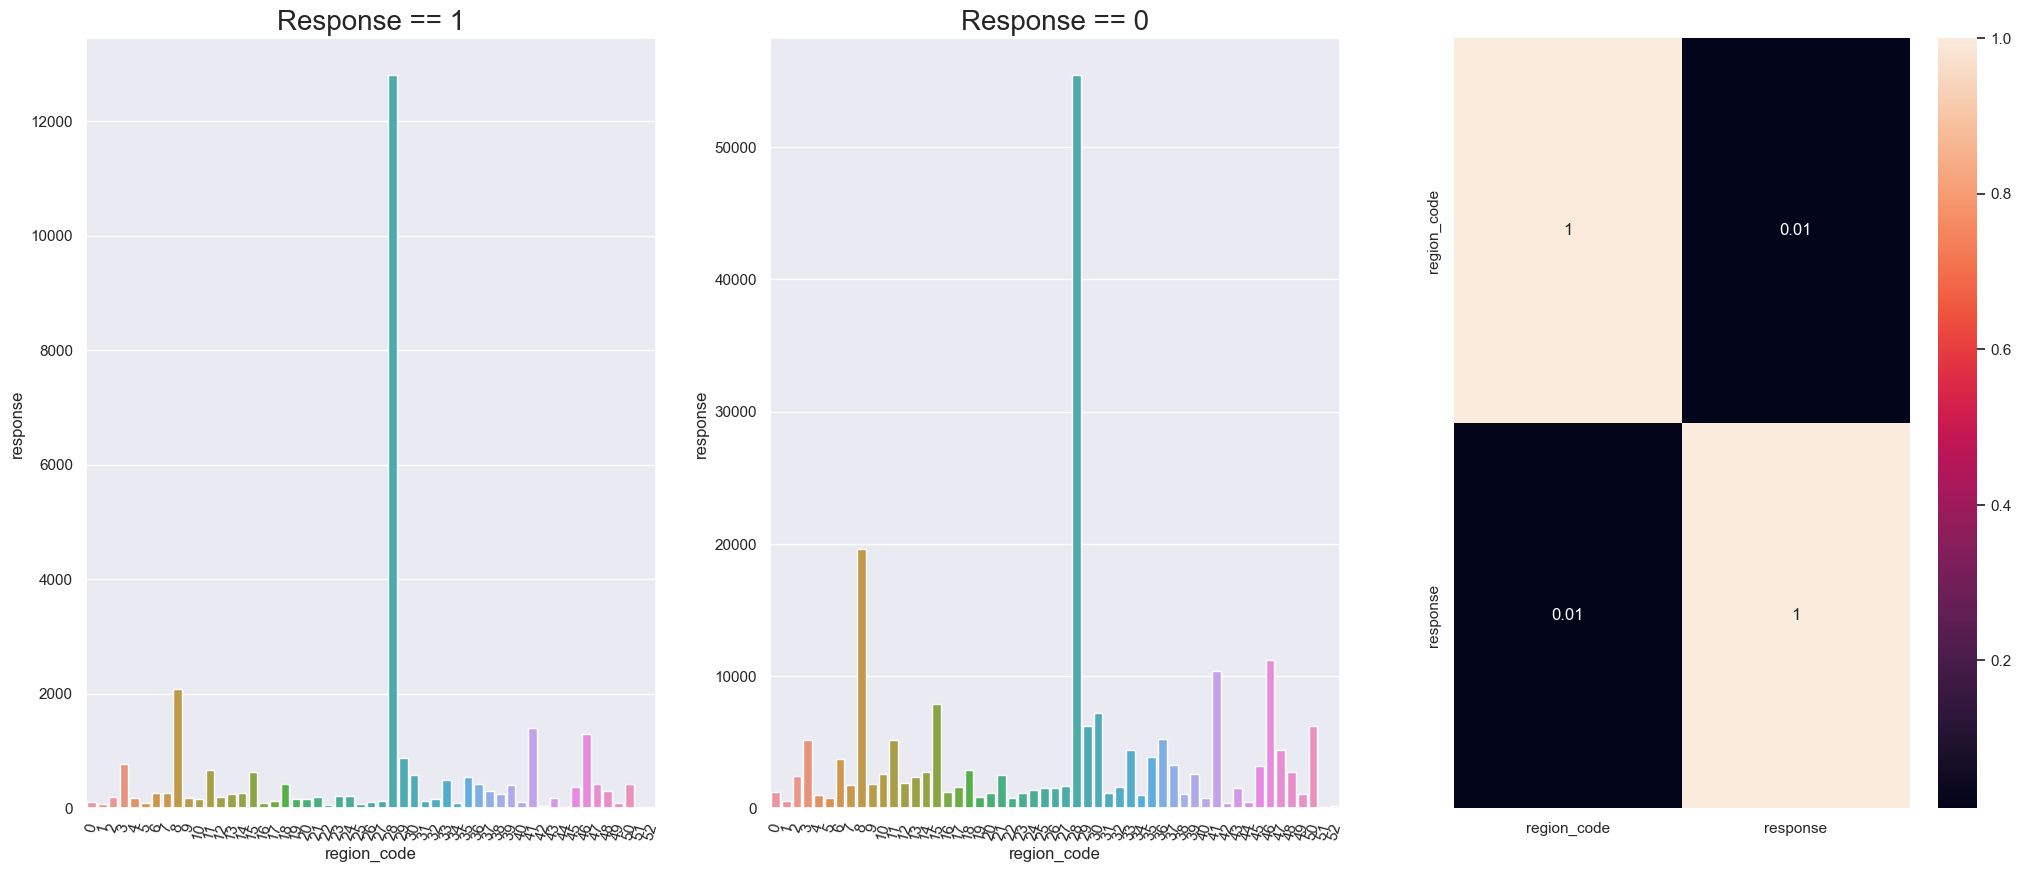

In [168]:
h8 = aux[['response', 'region_code']].groupby('region_code').count().reset_index()
h8_ = aux1[['response', 'region_code']].groupby('region_code').count().reset_index()

plt.subplot(1, 3, 1)
plt.title('Response == 1', fontsize=20)
ax = sns.barplot(data=h8, x='region_code', y='response')
plt.xticks(rotation=75)

plt.subplot(1, 3, 2)
plt.title('Response == 0', fontsize=20)
sns.barplot(data=h8_ , x='region_code', y='response')
plt.xticks(rotation=75)

plt.subplot(1, 3, 3)
sns.heatmap(df4[['region_code', 'response']].corr(method='pearson'), annot=True);

## 4.3. Multivariate Analysis

In [169]:
num_attributes = df4.select_dtypes(include=['float', 'int']).drop(['id'], axis = 1)
cat_attributes = df4.select_dtypes(exclude=['float', 'int'])

### 4.3.1 Numerical Attributes

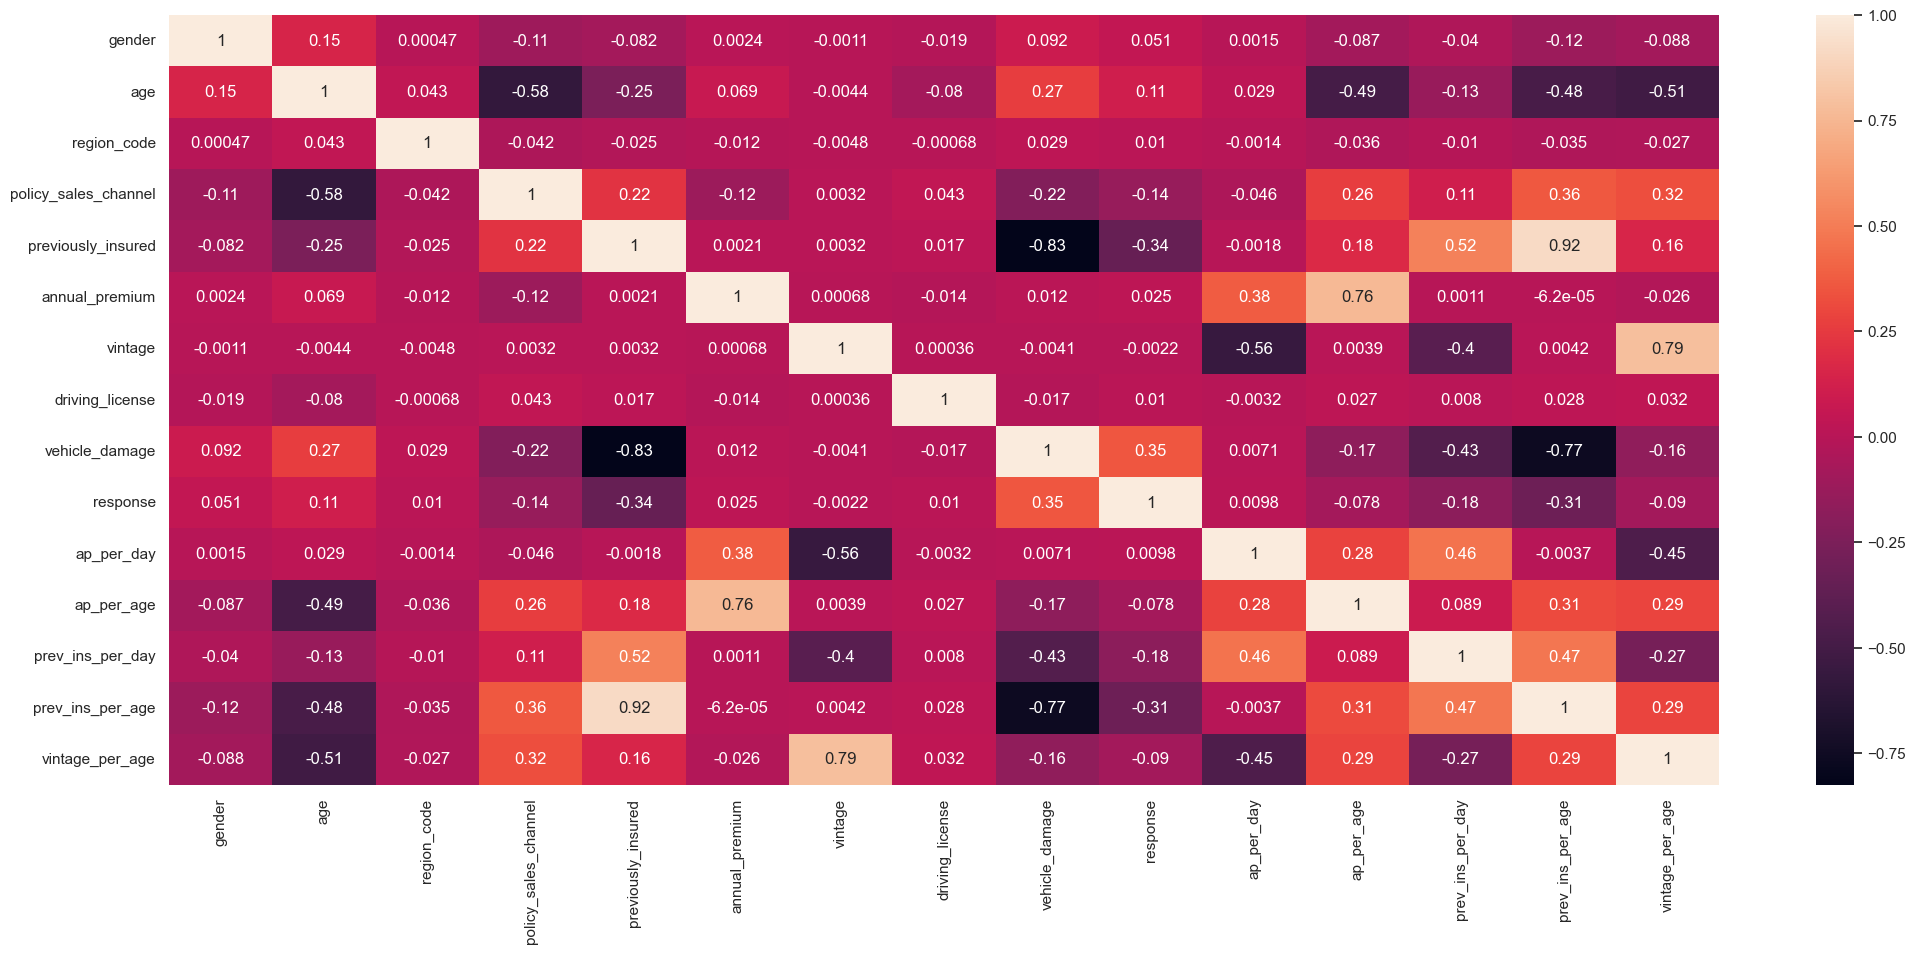

In [170]:
sns.heatmap(num_attributes.corr(method='pearson'), annot=True);

# 5.0. DATA PREPARATION

In [171]:
df5 = df4.copy()

## 5.1 Training Dataset

### 5.1.1 Standardzation

In [172]:
# annual_premium

ss = pp.StandardScaler()

df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)
#pickle.dump(ss, open('/Users/Victor/Desktop/repos/pa004_health_insurance/src/features/annual_premium_scaler.pkl', 'wb'))

### 5.1.2 Reescaling

In [173]:
# age
age_mms = pp.MinMaxScaler()
vintage_mms = pp.MinMaxScaler()
ap_per_day_mms = pp.MinMaxScaler()
ap_per_age_mms = pp.MinMaxScaler()
prev_ins_per_day_mms = pp.MinMaxScaler()
prev_ins_per_age_mms = pp.MinMaxScaler()


df5['age'] = age_mms.fit_transform(df5[['age']].values)
df5['vintage'] = vintage_mms.fit_transform(df5[['vintage']].values)

df5['ap_per_day'] = ap_per_day_mms.fit_transform(df5[['ap_per_day']].values)
df5['ap_per_age'] = ap_per_age_mms.fit_transform(df5[['ap_per_age']].values)

df5['prev_ins_per_day'] = prev_ins_per_day_mms.fit_transform(df5[['prev_ins_per_day']].values)
df5['prev_ins_per_age'] = prev_ins_per_age_mms.fit_transform(df5[['prev_ins_per_age']].values)


#pickle.dump(age_mms, open('/Users/Victor/Desktop/repos/pa004_health_insurance/src/features/age_scaler.pkl', 'wb'))
#pickle.dump(vintage_mms, open('/Users/Victor/Desktop/repos/pa004_health_insurance/src/features/vintage_scaler.pkl', 'wb'))
#pickle.dump(ap_per_day_mms, open('/Users/Victor/Desktop/repos/pa004_health_insurance/src/features/ap_per_day_scaler.pkl', 'wb'))
#pickle.dump(ap_per_age_mms, open('/Users/Victor/Desktop/repos/pa004_health_insurance/src/features/ap_per_age_scaler.pkl', 'wb'))
#pickle.dump(prev_ins_per_day_mms, open('/Users/Victor/Desktop/repos/pa004_health_insurance/src/features/prev_ins_per_day_scaler.pkl', 'wb'))
#pickle.dump(prev_ins_per_age_mms, open('/Users/Victor/Desktop/repos/pa004_health_insurance/src/features/prev_ins_per_age_scaler.pkl', 'wb'))

### 5.1.3 Encoders


In [174]:
# region code
target_encoding_region_code = df5.groupby('region_code')['response'].mean()

df5.loc[:, 'region_code'] = df5['region_code'].map(target_encoding_region_code)
#pickle.dump(target_encoding_region_code, open('/Users/Victor/Desktop/repos/pa004_health_insurance/src/features/target_encoder_region_code.pkl', 'wb'))

In [175]:
# vehicle age

df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])

In [176]:
# policy sales channel
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5)

df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)
#pickle.dump(target_encoding_region_code, open('/Users/Victor/Desktop/repos/pa004_health_insurance/src/features/fe_policy_sales_channel.pkl', 'wb'))

## 5.2 Validation Dataset

### 5.2.1 Standardzation

In [177]:
# annual_premium
x_validation['annual_premium'] = ss.transform(x_validation[['annual_premium']].values)

### 5.2.2 Reescaling

In [178]:
x_validation['age'] = age_mms.transform(x_validation[['age']].values)
x_validation['vintage'] = vintage_mms.transform(x_validation[['vintage']].values)

x_validation['ap_per_day'] = ap_per_day_mms.transform(x_validation[['ap_per_day']].values)
x_validation['ap_per_age'] = ap_per_age_mms.transform(x_validation[['ap_per_age']].values)

x_validation['prev_ins_per_day'] = prev_ins_per_day_mms.transform(x_validation[['prev_ins_per_day']].values)
x_validation['prev_ins_per_age'] = prev_ins_per_age_mms.transform(x_validation[['prev_ins_per_age']].values)

### 5.2.3 Encoding

In [179]:
# region code
x_validation.loc[:, 'region_code'] = x_validation['region_code'].map(target_encoding_region_code)

# vehicle age
x_validation = pd.get_dummies(x_validation, prefix='vehicle_age', columns=['vehicle_age'])

# policy sales channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map(fe_policy_sales_channel)

# 6.0. FEATURE SELECTION

In [80]:
x_train_n = df5.loc[:, ~df5.columns.isin(['id', 'response'])]
y_train_n = y_train.values

## 6.1. Feature Importance

In [68]:
forest = en.ExtraTreesClassifier(n_estimators = 250, random_state=0, n_jobs = -1)
feature_names = [f"feature {i}" for i in range(x_train_n.shape[1])]

forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                        feature  importance
0                    ap_per_day    0.126901
0               vintage_per_age    0.126487
0                       vintage    0.122480
0                    ap_per_age    0.119721
0                           age    0.107937
0                annual_premium    0.103874
0                   region_code    0.078237
0                vehicle_damage    0.063907
0          policy_sales_channel    0.056765
0            previously_insured    0.040335
0              prev_ins_per_age    0.019385
0      vehicle_age_below_1_year    0.012057
0                        gender    0.010185
0  vehicle_age_between_1_2_year    0.005199
0              prev_ins_per_day    0.004020
0       vehicle_age_over_2_year    0.001962
0               driving_license    0.000548


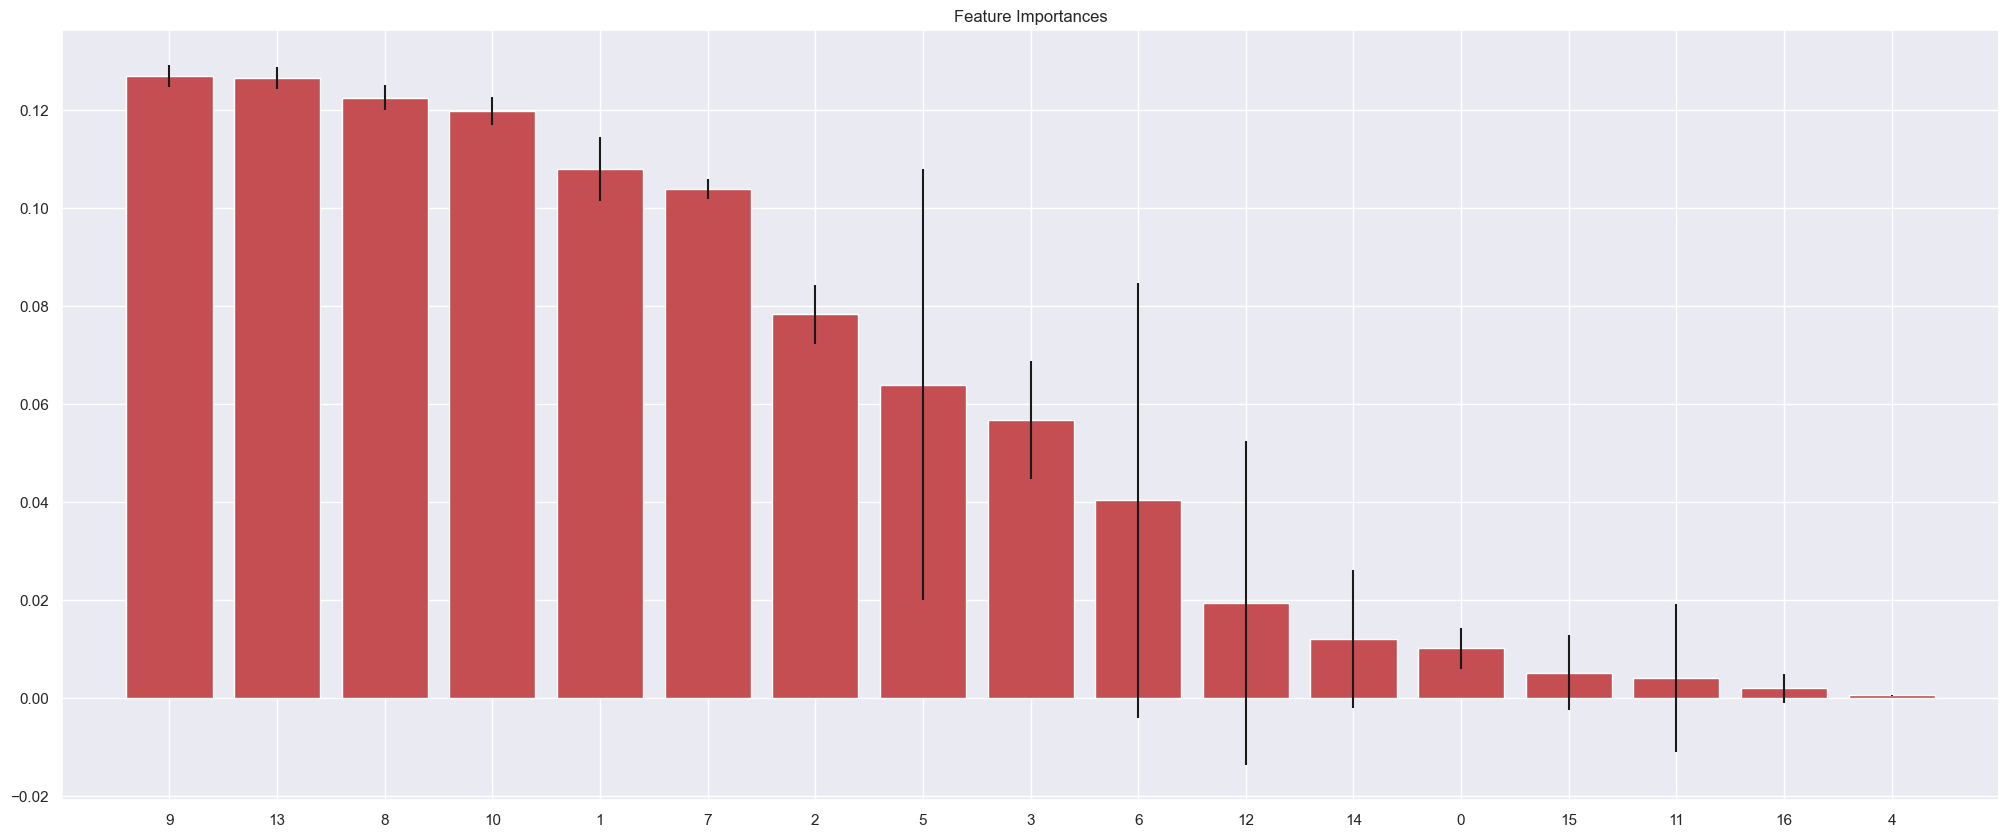

In [69]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip(x_train_n, importances):
    aux = pd.DataFrame({'feature': i, 'importance':j}, index=[0])
    df = pd.concat([df, aux], axis = 0)

print(df.sort_values('importance' ,ascending= False))
    
# Plot
plt.figure()
plt.title("Feature Importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align = "center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

## 6.2. Best Features

In [180]:
cols_selected = ['ap_per_day',
                 'vintage',
                 'ap_per_age',
                 'annual_premium',
                 'age',
                 'region_code',
                 'vehicle_damage',
                 'policy_sales_channel',
                 'previously_insured']

x_train = df5[cols_selected]
x_val = x_validation[cols_selected].fillna(0)
y_val = y_validation.copy()

# 7.0 MACHINE LEARNING MODELING

## 7.1. K-NearestNeighbours

,Model Name,Precision at k,Recall at k
0,K-NN,0.2914,0.6296


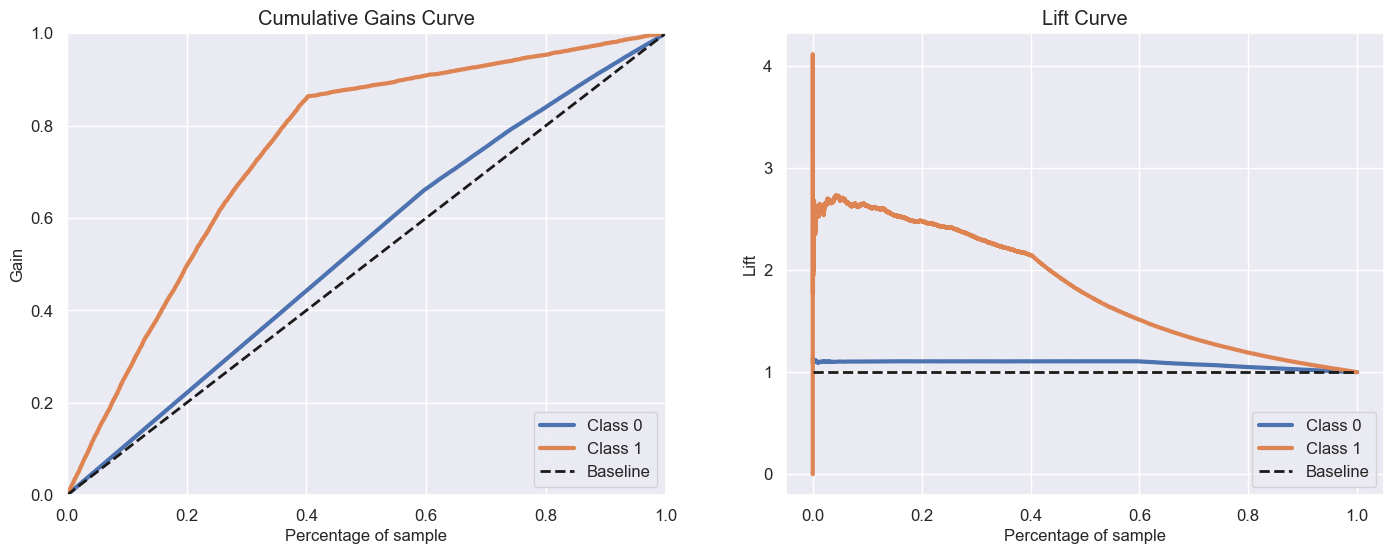

In [95]:
knn = neighbors.KNeighborsClassifier(n_neighbors=7)

knn_model = knn.fit(x_train, y_train)

y_prob_knn = knn_model.predict_proba(x_val)

knn_result = precision_recall_at_k('K-NN', x_val, y_val, y_prob_knn)
display(knn_result)

fix, axs = plt.subplots(ncols =2 , figsize=(17, 6))
skplt.metrics.plot_cumulative_gain(y_val, y_prob_knn, ax=axs[0])
skplt.metrics.plot_lift_curve(y_val, y_prob_knn, ax=axs[1]);

### 7.1.1 Cross Validation

In [116]:
knn_cv = cross_validation('K-NN', knn_model, x_train, x_val, y_train, y_val, 5, 2)
knn_cv

,Model Name,Precision,Recall
0,K-NN,0.279+/-0.0,0.711+/-0.0


## 7.2. Logistic Regression

,Model Name,Precision at k,Recall at k
0,Logistic Regression,0.2996,0.6475


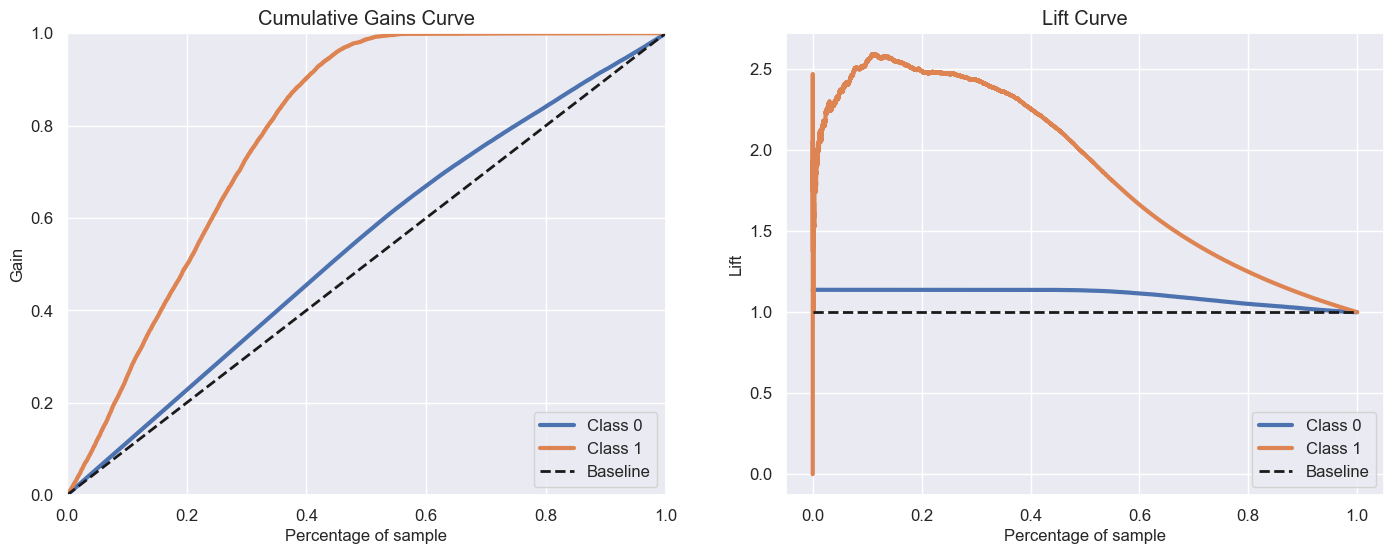

In [101]:
lr = lm.LogisticRegression(class_weight='balanced', max_iter = 200)


lr_model = lr.fit(x_train, y_train)

y_prob = lr_model.predict_proba(x_val)

lr_result = precision_recall_at_k('Logistic Regression', x_val, y_val, y_prob)
display(lr_result)

fix, axs = plt.subplots(ncols =2 , figsize=(17, 6))
skplt.metrics.plot_cumulative_gain(y_val, y_prob, ax=axs[0])
skplt.metrics.plot_lift_curve(y_val, y_prob, ax=axs[1]);


### 7.2.1 Cross Validation

In [117]:
lr_cv = cross_validation('Logistic Regression', lr_model, x_train, x_val, y_train, y_val, 5, 2)
lr_cv

,Model Name,Precision,Recall
0,Logistic Regression,0.292+/-0.0,0.745+/-0.0


## 7.3. Random Forest Classifier

,Model Name,Precision at k,Recall at k
0,Random Forest Classifier,0.3043,0.6576


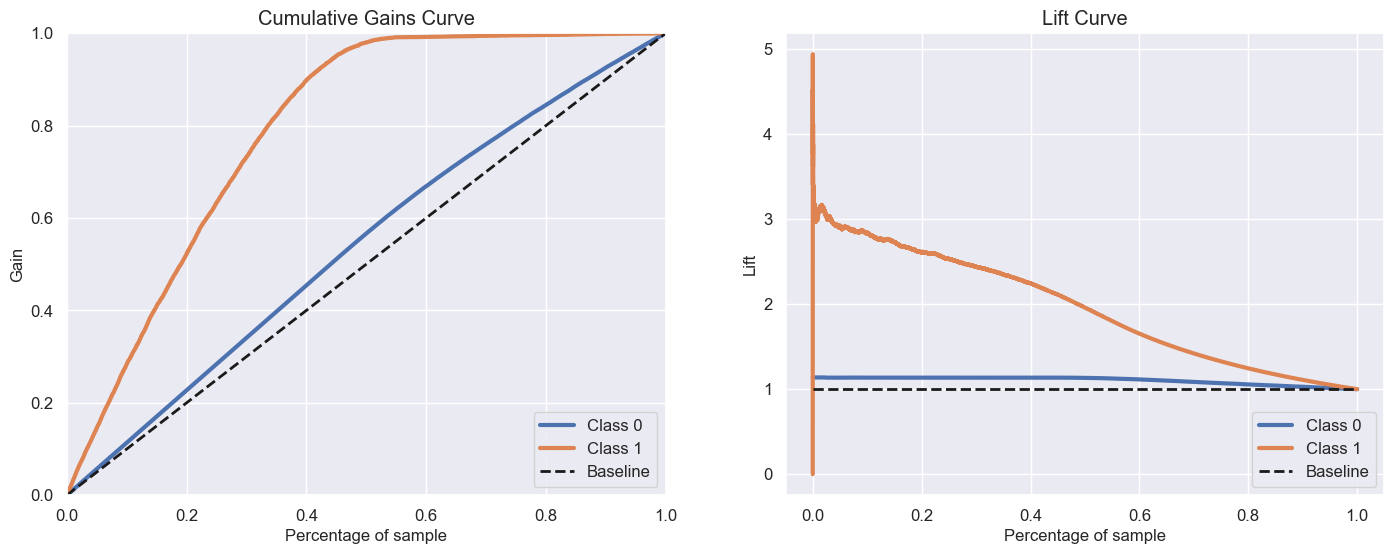

In [103]:
# model
rf = en.RandomForestClassifier(n_estimators= 100, n_jobs = -1, random_state=42)

model_rf = rf.fit(x_train, y_train)

# predict
y_prob = model_rf.predict_proba(x_val)

rf_result = precision_recall_at_k('Random Forest Classifier', x_val, y_val, y_prob)
display(rf_result)

# plot
fix, axs = plt.subplots(ncols =2 , figsize=(17, 6))
skplt.metrics.plot_cumulative_gain(y_val, y_prob, ax=axs[0])
skplt.metrics.plot_lift_curve(y_val, y_prob, ax=axs[1]);

### 7.3.1 Cross Validation

In [118]:
rf_cv = cross_validation('Random Forest Classifier', model_rf, x_train, x_val, y_train, y_val, 5, 2)
rf_cv

,Model Name,Precision,Recall
0,Random Forest Classifier,0.296+/-0.0,0.757+/-0.0


## 7.4. XGBoost Classifier

,Model Name,Precision at k,Recall at k
0,XGboost Classifier,0.3293,0.7115


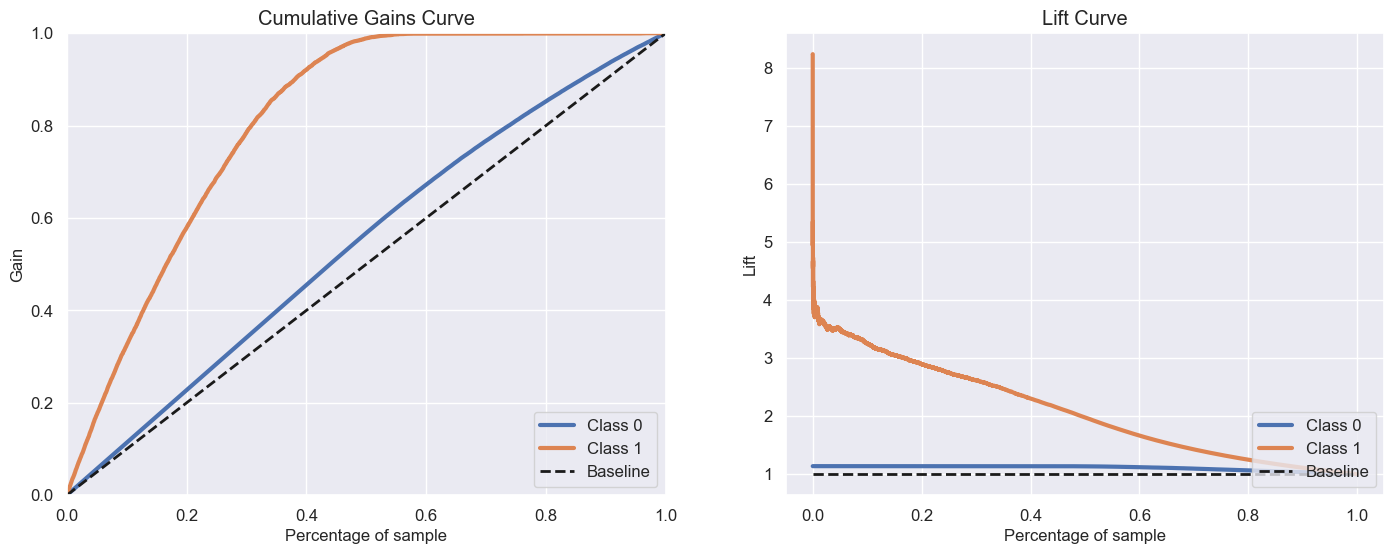

In [57]:
# model
xgb_model = xgb.XGBClassifier(n_estimators=100,
                              eta=0.01,
                              max_depth=10,
                              subsample=0.7,
                              colsample_bytree=0.9).fit(x_train, y_train)

# predict
y_prob = xgb_model.predict_proba(x_val)

xgb_result = precision_recall_at_k('XGboost Classifier', x_val, y_val, y_prob)
display(xgb_result)

# plot
fix, axs = plt.subplots(ncols =2 , figsize=(17, 6))
skplt.metrics.plot_cumulative_gain(y_val, y_prob, ax=axs[0])
skplt.metrics.plot_lift_curve(y_val, y_prob, ax=axs[1]);

### 7.4.1 Cross Validation

In [119]:
xgb_cv = cross_validation('XGBoost Classifier', xgb_model, x_train, x_val, y_train, y_val, 5, 2)
xgb_cv

,Model Name,Precision,Recall
0,XGBoost Classifier,0.314+/-0.0,0.802+/-0.0


## 7.5. Light Gradient Boost Machine Classifier

,Model Name,Precision at k,Recall at k
0,LGBM Classifier,0.3324,0.7183


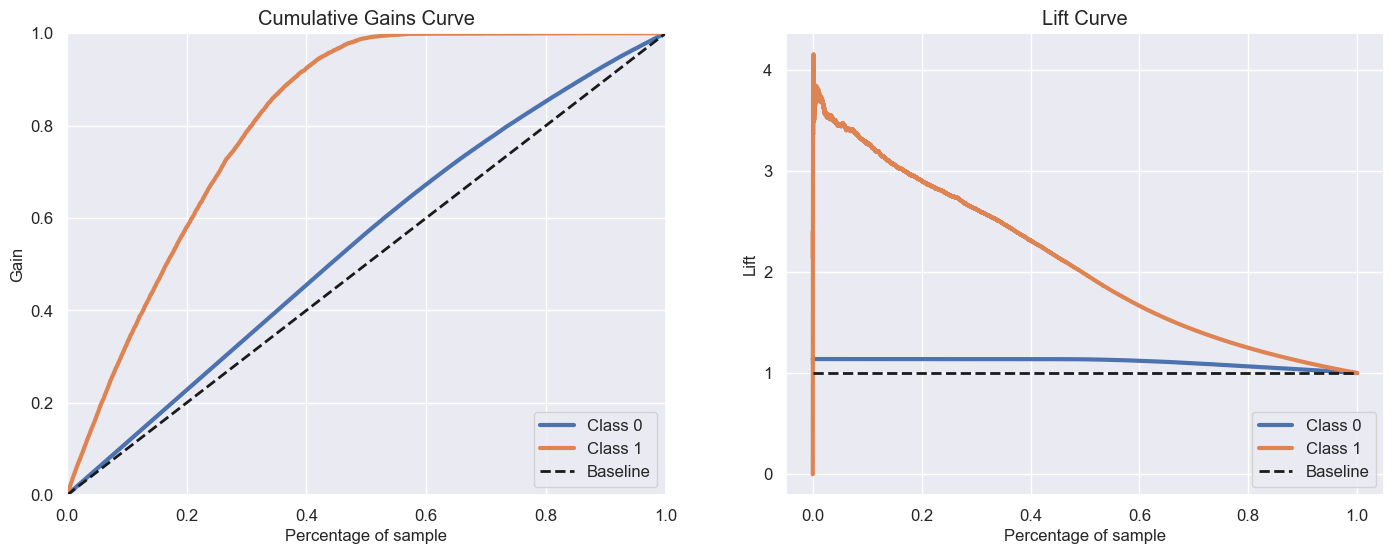

In [111]:
lgbm_model = LGBMClassifier().fit(x_train, y_train)

y_prob = lgbm_model.predict_proba(x_val)

lgbm_result = precision_recall_at_k('LGBM Classifier', x_val, y_val, y_prob)
display(lgbm_result)

fix, axs = plt.subplots(ncols =2 , figsize=(17, 6))
skplt.metrics.plot_cumulative_gain(y_val, y_prob, ax=axs[0])
skplt.metrics.plot_lift_curve(y_val, y_prob, ax=axs[1]);

### 7.5.1 Cross Validation

In [120]:
lgbm_cv = cross_validation('LGBM Classifier', lgbm_model, x_train, x_val, y_train, y_val, 5, 2)
lgbm_cv

,Model Name,Precision,Recall
0,LGBM Classifier,0.316+/-0.0,0.806+/-0.0


## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [114]:
single_performance = pd.concat( [lr_result, rf_result, xgb_result, lgbm_result] )
single_performance.sort_values('Recall at k', ascending= False)

,Model Name,Precision at k,Recall at k
0,LGBM Classifier,0.3324,0.7183
0,XGboost Classifier,0.3293,0.7115
0,Random Forest Classifier,0.3043,0.6576
0,Logistic Regression,0.2996,0.6475


### 7.6.2 Real Performance

The chosen model was LightGBM, for the following reasons:

* Best performance
* Fast training
* Low computational cost

In [121]:
modelling_result = pd.concat( [lr_cv, rf_cv, xgb_cv, lgbm_cv] )
modelling_result.sort_values('Recall', ascending= False)

,Model Name,Precision,Recall
0,LGBM Classifier,0.316+/-0.0,0.806+/-0.0
0,XGBoost Classifier,0.314+/-0.0,0.802+/-0.0
0,Random Forest Classifier,0.296+/-0.0,0.757+/-0.0
0,Logistic Regression,0.292+/-0.0,0.745+/-0.0


# 8.0 HYPERPARAMETER FINE TUNNING

## 8.1. Random Search

### 8.1.1 LGBM Classifier

In [93]:
param = {
    'boosting_type': ['gbdt', 'dart'],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 40, 60, 80],
    'n_estimators': [500, 1000, 2000, 3000],
    'max_depth': [3, 5, 10],
    'min_child_samples': [20, 40, 100],
    'subsample': [0.1, 0.3, 0.7, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'reg_alpha': [1, 3, 5, 7],
    'reg_lambda':[1, 3, 5, 7],
    'random_state': [42],
    'class_weight':['balanced']
}

MAX_EVAL = 5 

In [94]:
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    hp = {k: random.sample(v,1)[0] for k, v in param.items()}
    print(hp)
    
    lgbm_model_tunned = LGBMClassifier( 
                                   boosting_type=hp['boosting_type'],
                                   learning_rate=hp['learning_rate'],
                                   colsample_bytree=hp['colsample_bytree'],
                                   subsample=hp['subsample'],
                                   max_depth=hp['max_depth'],
                                   reg_alpha=hp['reg_alpha'],
                                   reg_lambda=hp['reg_lambda'],
                                   num_leaves=hp['num_leaves'],
                                   random_state=hp['random_state'],
                                   min_child_samples=hp['min_child_samples'],
                                   n_estimators=hp['n_estimators'],
                                   class_weight=hp['class_weight']).fit(x_train, y_train)
    
    #performance
    result = cross_validation('LGBM Classifier', lgbm_model_tunned, x_train, x_val, y_train, y_val, 5, 2)
    final_result = pd.concat([final_result, result])

{'boosting_type': 'gbdt', 'learning_rate': 0.1, 'num_leaves': 20, 'n_estimators': 1000, 'max_depth': 10, 'min_child_samples': 40, 'subsample': 0.1, 'colsample_bytree': 0.7, 'reg_alpha': 1, 'reg_lambda': 5, 'random_state': 42, 'class_weight': 'balanced'}
{'boosting_type': 'dart', 'learning_rate': 0.1, 'num_leaves': 40, 'n_estimators': 2000, 'max_depth': 5, 'min_child_samples': 20, 'subsample': 0.7, 'colsample_bytree': 0.8, 'reg_alpha': 1, 'reg_lambda': 1, 'random_state': 42, 'class_weight': 'balanced'}
{'boosting_type': 'gbdt', 'learning_rate': 0.01, 'num_leaves': 60, 'n_estimators': 3000, 'max_depth': 3, 'min_child_samples': 100, 'subsample': 0.9, 'colsample_bytree': 0.6, 'reg_alpha': 3, 'reg_lambda': 7, 'random_state': 42, 'class_weight': 'balanced'}
{'boosting_type': 'dart', 'learning_rate': 0.01, 'num_leaves': 60, 'n_estimators': 3000, 'max_depth': 10, 'min_child_samples': 40, 'subsample': 0.9, 'colsample_bytree': 0.8, 'reg_alpha': 5, 'reg_lambda': 7, 'random_state': 42, 'class_weig

In [195]:
final_result

,Model Name,Precision,Recall
0,LGBM Classifier,0.313+/-0.0,0.8+/-0.0
0,LGBM Classifier,0.315+/-0.0,0.803+/-0.0
0,LGBM Classifier,0.316+/-0.0,0.807+/-0.0
0,LGBM Classifier,0.316+/-0.0,0.807+/-0.0
0,LGBM Classifier,0.315+/-0.0,0.803+/-0.0


In [281]:
param = {
    'n_estimators': [100, 200, 300, 400, 500, 1000],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
}

MAX_EVAL = 5

In [284]:
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    hp = {k: random.sample(v,1)[0] for k, v in param.items()}
    print(hp)
    
# model
    xgb_model = xgb.XGBClassifier(n_estimators=hp['n_estimators'],
                                  eta=hp['eta'],
                                  max_depth=hp['max_depth'],
                                  subsample=hp['subsample'],
                                  colsample_bytree=hp['colsample_bytree']).fit(x_train, y_train)

    #predict
    y_prob = xgb_model.predict_proba(x_val)
    
    #performance
    result = cross_validation('XGBoost Classifier', xgb_model, x_train, x_val, y_train, y_val, 5, 1)
    final_result = pd.concat([final_result, result])

final_result

{'n_estimators': 500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 8}
{'n_estimators': 400, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 15}
{'n_estimators': 400, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 15}
{'n_estimators': 500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 3}
{'n_estimators': 300, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 8}


,Model Name,Precision,Recall
0,XGBoost Classifier,0.313+/-0.0,0.8+/-0.0
0,XGBoost Classifier,0.314+/-0.0,0.801+/-0.0
0,XGBoost Classifier,0.314+/-0.0,0.801+/-0.0
0,XGBoost Classifier,0.316+/-0.0,0.806+/-0.0
0,XGBoost Classifier,0.315+/-0.0,0.804+/-0.0


## 8.2. Model Training with Test Dataset

### 8.2.1 Test Data Preparation

In [181]:
# ==================== CHANGE DTYPES ==================== # 

x_test['region_code'] = x_test['region_code'].astype('int64')
x_test['policy_sales_channel'] = x_test['policy_sales_channel'].astype('int64')
x_test['gender'] = x_test['gender'].apply(lambda x: 1 if x == 'Male' else 0)


# ==================== FEATURE ENGINEERING ==================== # 


x_test['vehicle_damage'] = x_test['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)


x_test['vehicle_age']  = x_test['vehicle_age'].apply(lambda x: 'over_2_year' if x == '> 2 Years' else 
                                                         'between_1_2_year' if x == '1-2 Year' else 
                                                         'below_1_year')


x_test['ap_per_day'] = x_test['annual_premium'] / x_test['vintage']
x_test['ap_per_age'] = x_test['annual_premium'] / x_test['age']
x_test['prev_ins_per_day'] = x_test['previously_insured'] / x_test['vintage']
x_test['prev_ins_per_age'] = x_test['previously_insured'] / x_test['age']
x_test['vintage_per_age'] = x_test['vintage'] / x_test['age']


# ==================== DATA PREPARATION ==================== # 


x_test['annual_premium'] = ss.transform(x_test[['annual_premium']].values)
x_test['age'] = age_mms.transform(x_test[['age']].values)
x_test['vintage'] = vintage_mms.transform(x_test[['vintage']].values)
x_test['ap_per_day'] = ap_per_day_mms.transform(x_test[['ap_per_day']].values)
x_test['ap_per_age'] = ap_per_age_mms.transform(x_test[['ap_per_age']].values)
x_test['prev_ins_per_day'] = prev_ins_per_day_mms.transform(x_test[['prev_ins_per_day']].values)
x_test['prev_ins_per_age'] = prev_ins_per_age_mms.transform(x_test[['prev_ins_per_age']].values)

x_test.loc[:, 'region_code'] = x_test['region_code'].map(target_encoding_region_code)
x_test.loc[:, 'policy_sales_channel'] = x_test['policy_sales_channel'].map(fe_policy_sales_channel)
x_test = pd.get_dummies(x_test, prefix='vehicle_age', columns=['vehicle_age'])

x_test = x_test[cols_selected]

,Model Name,Precision at k,Recall at k
0,XGboost Classifier,0.309,0.821


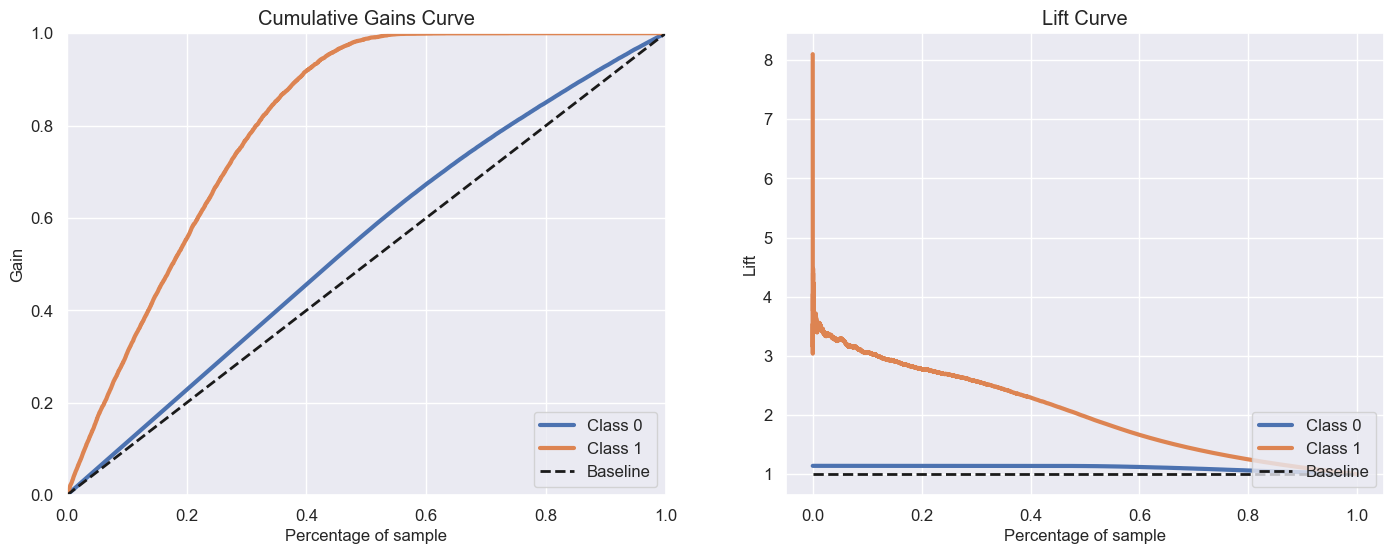

In [182]:
param_tunned = {'n_estimators': 500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 3}

# model
xgb_model_tunned = xgb.XGBClassifier(n_estimators=param_tunned['n_estimators'],
                                     eta=param_tunned['eta'],
                                     max_depth=param_tunned['max_depth'],
                                     subsample=param_tunned['subsample'],
                                     colsample_bytree=param_tunned['colsample_bytree'],
                                     min_child_weight=param_tunned['min_child_weight'],
                                     scale_pos_weight=1).fit(np.concatenate([x_train, x_val]), np.concatenate([y_train, y_val]))

#predict
xgb_tunned_yprob = xgb_model_tunned.predict_proba(x_test)

xgb_result = precision_recall_at_k('XGboost Classifier', x_test, y_test, xgb_tunned_yprob)
display(xgb_result)

# plot
fix, axs = plt.subplots(ncols =2 , figsize=(17, 6))

skplt.metrics.plot_cumulative_gain(y_test, xgb_tunned_yprob, ax=axs[0])
skplt.metrics.plot_lift_curve(y_test, xgb_tunned_yprob, ax=axs[1]);

### 8.2.3 LGBM Train/Val + Test

,Model Name,Precision at k,Recall at k
0,LGBM Classifier,0.31,0.8238


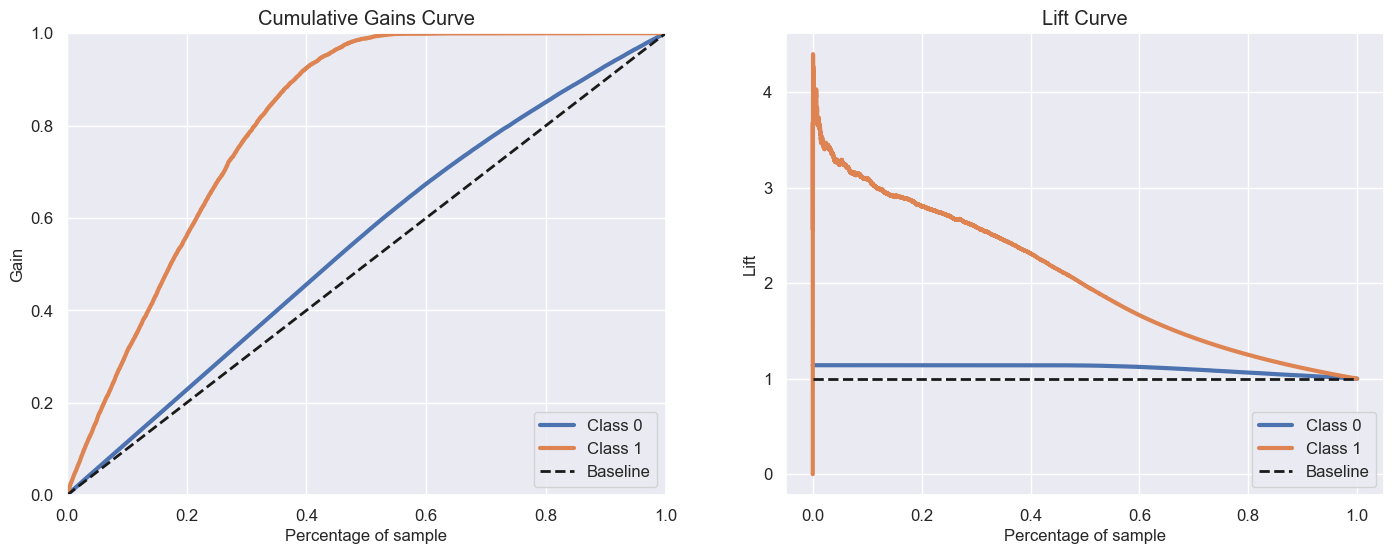

In [102]:
lgbm_model_tunned = LGBMClassifier(boosting_type =  'gbdt' ,  learning_rate = 0.01,  num_leaves = 60,  n_estimators = 3000,  max_depth = 3,  min_child_samples = 100,  subsample = 0.9,  colsample_bytree = 0.6,  reg_alpha = 3,  reg_lambda = 7,  random_state = 42,  class_weight =  'balanced' ).fit(np.concatenate([x_train,  x_val]), np.concatenate([y_train, y_val]))

lgbm_tunned_yhat = lgbm_model_tunned.predict_proba(x_test)

## Precision and Recall at k
lgbm_result = precision_recall_at_k('LGBM Classifier', x_test, y_test, lgbm_tunned_yhat)
display(lgbm_result)


# plot
fix, axs = plt.subplots(ncols =2 , figsize=(17, 6))

skplt.metrics.plot_cumulative_gain(y_test, lgbm_tunned_yhat, ax=axs[0])
skplt.metrics.plot_lift_curve(y_test, lgbm_tunned_yhat, ax=axs[1]);

In [103]:
ranking_score(x_test, y_test, lgbm_tunned_yhat)

,k,precision_at_k,recall_at_k,score
0,0.05,0.401247,0.162482,0.812124
1,0.10,0.382483,0.309818,0.787177
2,0.15,0.359392,0.436695,0.766321
3,0.20,0.346371,0.561180,0.743764
4,0.25,0.333639,0.675701,0.712542
5,0.30,0.319576,0.776671,0.667447
6,0.35,0.302877,0.858775,0.599849
7,0.40,0.285351,0.924671,0.508616
8,0.45,0.264723,0.965059,0.399319
9,0.50,0.244121,0.988840,0.211432


## 8.3. Final Model

In [196]:
#juntar treino, validação e teste
X = np.concatenate([x_train, x_val, x_test])
y = np.concatenate([y_train, y_val, y_test])

# model
final_model = LGBMClassifier(boosting_type =  'gbdt' ,  
                             learning_rate = 0.01,  
                             num_leaves = 60,  
                             n_estimators = 3000,  
                             max_depth = 3,  
                             min_child_samples = 100,  
                             subsample = 0.9,  
                             colsample_bytree = 0.6, 
                             reg_alpha = 3,  
                             reg_lambda = 7,  
                             random_state = 42,  
                             class_weight =  'balanced' ).fit(X, y)

In [198]:
#pickle.dump(final_model, open( '/Users/Victor/Desktop/repos/pa004_health_insurance/src/models/xgboost.pkl', 'wb'))
pickle.dump(final_model, open('/Users/Victor/Desktop/repos/pa004_health_insurance/src/models/lgbm.pkl', 'wb'))